<a href="https://colab.research.google.com/github/Watson15/GHIPrediction/blob/main/BCDataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random, os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
#import seaborn as sns
from constants import COLUMN_NAMES, USECOLS_CLOUD, DTYPE_CLOUD, USECOLS_NON_CLOUD, DTYPE_NON_CLOUD
%load_ext autoreload
%autoreload 2

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


# Function Declaration and loading CSVs

In [ ]:
# path = r'/content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC'
raw_path = 'Datasets/CWEEDS_2020_BC_raw'
clean_non_cloud_path = 'Datasets/CWEEDS_2020_BC_cleaned_non_cloud'
clean_cloud_path = 'Datasets/CWEEDS_2020_BC_cleaned_cloud'
csv_files = glob.glob(os.path.join(raw_path, "*.csv"))

#print(csv_files)

In [5]:
import re
def getStationTimePeriodFromYears(csv_file):
  match = re.search(r'(\d{4})-(\d{4})', csv_file)
  if match:
    start_year = int(match.group(1))
    end_year = int(match.group(2))
    #print(start_year, end_year)  # Output: 2005 2017
    return (start_year, end_year)

In [4]:
# def get_stations_name_Lat_Long(csv_files):
#   DegreeLatitudes = []
#   DegreeLongitudes = []
#   DegreeLogitudesTimes2 = []
#   #FileName = []
#   Station = []
#   StationTimePeriodStart = []
#   StationTimePeriodEnd = []
#   for f in csv_files:
#       df = pd.read_csv(f, delimiter=',', nrows=2, on_bad_lines='skip')
#       #The ratio between longitude and latitude is 360:180; meaning for every 1 degree of latitude, there are 2 degrees of longitude, as there are 360 degrees of longitude and 180 degrees of latitude on Earth.
#       #Therefore when getting latitude data we multiply it by 2 to make it more accurate for distance calcs
#       TimePeriod = getStationTimePeriodFromYears(f)
#       StationTimePeriodStart.append(TimePeriod[0])
#       StationTimePeriodEnd.append(TimePeriod[1])
#       DegreeLatitudes.append(df['Degree latitude'][0])
#       DegreeLogitudesTimes2.append(df['Degree longitude'][0]*2)#Multiplied by 2 for training model but take away when analyzing and wanting to find real location for elevation
#       DegreeLongitudes.append(df['Degree longitude'][0])# Not Multiplied by 2 for analyzing and wanting to find real location for elevation
#       #FileName.append(f.split("\\")[-1])
#       Station.append(df['Climate station name'][0])
#   return pd.DataFrame({'Latitude': DegreeLatitudes, 'Longitude': DegreeLongitudes, 'LongitudeTimes2': DegreeLogitudesTimes2, "station": Station, "StartTime": StationTimePeriodStart, "EndTime": StationTimePeriodEnd})

In [5]:
# stationsName_lat_long_datadf = get_stations_name_Lat_Long(csv_files)
# lat_min = stationsName_lat_long_datadf["Latitude"].min()
# lat_max = stationsName_lat_long_datadf["Latitude"].max()
# long_min = stationsName_lat_long_datadf["Longitude"].min()
# long_max = stationsName_lat_long_datadf["Longitude"].max()
lat_min = 0
lat_max = 0
long_min = 0
long_max = 0

In [6]:
def normalize_lat_lon(lat, lon):
    norm_lat = (lat - lat_min) / (lat_max - lat_min)
    norm_lon = (lon - long_min) / (long_max - long_min)
    return norm_lat, norm_lon

In [7]:
#stationsName_lat_long_datadf[['norm_lat', 'norm_long']] = stationsName_lat_long_datadf.apply(lambda row: normalize_lat_lon(row['Latitude'], row['Longitude']), axis=1, result_type='expand')

In [8]:
# file_path = '/content/drive/MyDrive/Colab Notebooks/aaew'
file_path = 'Datasets/stationsName_lat_long_data.csv'
stationsName_lat_long_datadf = pd.read_csv(file_path, delimiter=',', on_bad_lines='skip')

In [9]:
def plot_stations_matplotlib(center_latlon, neighbors_df, all_stations_df, figsize=(8, 6)):
    center_lat, center_lon = center_latlon

    # Create set of picked station names for easy lookup
    picked_names = set(neighbors_df['station'])

    plt.figure(figsize=figsize)

    # Plot unpicked stations (from all_stations_df, excluding the neighbors and center)
    for _, row in all_stations_df.iterrows():
        if (row['Latitude'], row['Longitude']) == tuple(center_latlon):
            continue
        if row['station'] not in picked_names:
            plt.scatter(row['Longitude'], row['Latitude'], color='gray', alpha=0.9, label='_nolegend_')
            #plt.text(row['Longitude'] + 0.002, row['Latitude'], row['station'], fontsize=8, color='gray')

    # Plot the selected neighbor stations
    plt.scatter(
        neighbors_df['Longitude'],
        neighbors_df['Latitude'],
        color='blue',
        label='Picked Neighbors'
    )
    # for _, row in neighbors_df.iterrows():
    #     plt.text(row['Longitude'] + 0.002, row['Latitude'], row['station'], fontsize=9)

    # Plot the target station
    plt.scatter(center_lon, center_lat, color='red', marker='*', s=150, label='Target Station')
    #plt.text(center_lon + 0.002, center_lat, 'Target', fontsize=10, fontweight='bold')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Target Station and Spatially Diverse Neighbors')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

In [10]:
# Euclidean distance function
def euclidean_distance(lat1, lon1, lat2, lon2):
    distance_vector = ((lat2 - lat1), lon2 - lon1)
    return ((np.sqrt((lat2 - lat1)**2) + (lon2 - lon1)**2), distance_vector)

# Function to find the K nearest stations (not returning nearest station given)
def find_k_nearest_stations(df, station_name, k):
    if station_name not in df['station'].values:
        return f"Station {station_name} not found in the dataset."

    # Get the coordinates of the given station
    station_coords = df[df['station'] == station_name][['Latitude', 'Longitude']].values[0]
    lat1, lon1 = station_coords

    # Calculate the distance from the given station to all other stations
    df['distance'] = df.apply(lambda row: euclidean_distance(lat1, lon1, row['Latitude'], row['Longitude']), axis=1)#Not using normalized lat and long for distance

    # station_coords = df[df['station'] == station_name][['norm_lat', 'norm_long']].values[0]
    # lat1, lon1 = station_coords

    # # Calculate the distance from the given station to all other stations
    # df['distance'] = df.apply(lambda row: euclidean_distance(lat1, lon1, row['norm_lat'], row['norm_long']), axis=1)

    # Sort the DataFrame by distance and get the K nearest stations
    #nearest_stations = df[df['station'] != station_name].sort_values(by='distance').head(k)
    nearest_stations = df[df['station'] != station_name].sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(k)

    return nearest_stations[['station', 'norm_lat', 'norm_long', 'distance', 'StartTime', 'EndTime', 'Latitude', 'Longitude']]

In [11]:
def latlon_to_xy(lat, lon, lat0):
    """Simple equirectangular projection."""
    R = 6371  # radius in km
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return x, y

def compute_angle(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # Could return np.pi to maximize diversity if desired
    unit1 = vec1 / norm1
    unit2 = vec2 / norm2
    return np.arccos(np.clip(np.dot(unit1, unit2), -1.0, 1.0))

def makeDistanceTuple(distance, x, y):
  return (distance, (x,y))

def spatially_diverse_knn(df,station_name, k=3, candidate_pool=len(csv_files)):
  # spatially_diverse_knn_df
  #
  # This function selects the 'k' nearest stations to a given target station,
  # while ensuring that the selected neighbors are spatially diverse. Instead
  # of simply choosing the closest stations, it incorporates an angular diversity
  # criterion that selects stations spread out in different directions. This helps
  # avoid picking stations that are clustered in one region around the target.
  #
  # Parameters:
  #   - df: DataFrame containing station information (latitude, longitude, station_name)
  #   - center_latlon: Coordinates (latitude, longitude) of the target station
  #   - k: Number of neighbors to select (default is 3)
  #   - candidate_pool: Number of candidates to consider before selection (default is len(csv_files)=78)
  #
  # Returns:
  #   - A DataFrame with 'k' stations selected based on spatial diversity from the target
    # Exclude the center point if it exists in the set
    if station_name not in df['station'].values:
      return f"Station {station_name} not found in the dataset."

    center_latlon = df[df['station'] == station_name][['Latitude', 'Longitude']].values[0]
    mask = ~((df['Latitude'] == center_latlon[0]) & (df['Longitude'] == center_latlon[1]))
    df_filtered = df[mask].copy()
    #df_filtered['distance_vector'] = [(0.0, (0.0, 0.0))] * len(df_filtered)  # Initialize with default values

    # Convert to x/y coords
    lat0 = center_latlon[0]
    df_filtered['x'], df_filtered['y'] = latlon_to_xy(df_filtered['Latitude'], df_filtered['Longitude'], lat0)
    center_x, center_y = latlon_to_xy(center_latlon[0], center_latlon[1], lat0)
    center_xy = np.array([center_x, center_y])

    # Compute distances
    df_filtered['distance'] = np.linalg.norm(df_filtered[['x', 'y']].values - center_xy, axis=1)
    df_sorted = df_filtered.sort_values('distance').head(candidate_pool)
    df_sorted['distance'] = df_sorted.apply(lambda row: makeDistanceTuple(row['distance'], row['x'], row['y']), axis=1)
    selected_rows = []
    selected_xy = []

    for idx, row in df_sorted.iterrows():
        cand_xy = np.array([row['distance'][1][0], row['distance'][1][1]])
        if len(selected_xy) == 0: #gets closest station
            selected_rows.append(row)
            selected_xy.append(cand_xy)
        else:
            angles = [compute_angle(cand_xy - center_xy, s - center_xy) for s in selected_xy]
            min_angle = min(angles)
            if min_angle > np.radians(45) or len(selected_xy) < k // 2:
                selected_rows.append(row)
                selected_xy.append(cand_xy)
        if len(selected_rows) == k:
            break

    # selectedStations = pd.DataFrame(selected_rows).drop(columns=['x', 'y']).reset_index(drop=True)
    # selectedStations.rename(columns= {'distance_vector': 'distance'}, inplace=True)
    return pd.DataFrame(selected_rows).drop(columns=['x', 'y']).reset_index(drop=True), center_latlon

In [12]:
def find_nearest_station_given_long_lat(df,Longitude, Latitude):
    # Find the station with the smallest Euclidean distance to the given coordinates
    df['distance'] = df.apply(lambda row: euclidean_distance(Latitude, Longitude, row['Latitude'], row['Longitude']), axis=1)
    nearest_station = df.sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(1)
    return nearest_station[['station', 'Latitude', 'Longitude', 'distance', 'StartTime', 'EndTime']]

    #To get station name print(str(wanted_station.station.iloc[0]))

In [13]:
def find_nearest_station_given_normed_long_lat(df,Longitude_Normed, Latitude_Normed):
    # Find the station with the smallest Euclidean distance to the given coordinates
    df['distance'] = df.apply(lambda row: euclidean_distance(Longitude_Normed, Latitude_Normed, row['norm_lat'], row['norm_long']), axis=1)
    nearest_station = df.sort_values(by='distance', key=lambda x: x.apply(lambda y: y[0])).head(1)
    return nearest_station[['station', 'norm_lat', 'norm_long', 'distance', 'StartTime', 'EndTime','Latitude','Longitude']]

    #To get station name print(str(wanted_station.station.iloc[0]))

In [14]:
def modify_nearest_stations(nearest_stations):
    modified_nearest_stations = []
    for station in nearest_stations['station']:
        modified_station = station.replace(" ", "-")
        modified_nearest_stations.append(modified_station)
    return modified_nearest_stations

In [15]:
def find_stations_csv(stations, csvs):
    station_order = []
    nearest_stations_csvs = []
    for station in stations:
        for csv in csvs:
            if station.lower() in csv.lower():
                nearest_stations_csvs.append(csv)
                print(f"Station {station} found in {csv}")
                station_order.append(station)
                break
    return nearest_stations_csvs, station_order

In [16]:
def adjustWindDirection(wind_direction_degress, theta_relative):
#Adjusts auxillary stations wind direction to be relative to the wanted stations position
  # Adjust the wind direction by subtracting the relative angle
  adjusted_wind_direction = wind_direction_degress - theta_relative
  # Normalize to 0-360 degrees
  adjusted_wind_direction = (adjusted_wind_direction + 360) % 360
  return adjusted_wind_direction

In [17]:
usecols = [
    'Year Month Day Hour (YYYYMMDDHH)',
    'Global horizontal irradiance / kJ/m2',
    'Direct normal irradiance / kJ/m2',
    'Diffuse horizontal irradiance / kJ/m2',
    'Wind direction / 0-359 degrees',
    'Wind speed / 0.1 m/s'
]

dtype = {
    'Year Month Day Hour (YYYYMMDDHH)': str,  # Read as string initially to handle errors
    'Global horizontal irradiance / kJ/m2': str,
    'Direct normal irradiance / kJ/m2': str,
    'Diffuse horizontal irradiance / kJ/m2': str,
    'Wind direction / 0-359 degrees': str,
    'Wind speed / 0.1 m/s': str
}

In [18]:
def get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year):
    dfs = []
    for f in nearest_stations_csvs:
      # Read the CSV file with specified columns and data types
      df = pd.read_csv(f, delimiter=',', skiprows=2, index_col=False, usecols=usecols, dtype=dtype, on_bad_lines='skip')
      # Convert columns to numeric, coercing errors to NaN
      for col in usecols:
          if(col == 'Year Month Day Hour (YYYYMMDDHH)'):
              #keep as string
              df['Year Month Day Hour (YYYYMMDDHH)'] = [int(num) for num in df['Year Month Day Hour (YYYYMMDDHH)']]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']>min_start_year]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']<=max_end_year]#Data is between min_start_year and max_end_year to accomidate files that dont have the same amount of data
              df = df.drop(columns=[col], axis=1)
              continue

          if(col=='Wind direction / 0-359 degrees'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              radians = np.deg2rad(df[col])
              df['wind_dir_sin'] = np.sin(radians)
              df['wind_dir_cos'] = np.cos(radians)
              df = df.drop(columns=[col], axis=1)
              continue

          if(col == 'Wind speed / 0.1 m/s'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std
              continue

          if (col == 'Global horizontal irradiance / kJ/m2' or col == 'Direct normal irradiance / kJ/m2' or col == 'Diffuse horizontal irradiance / kJ/m2'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(9999, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              df[col] = (df[col] - mean) / std #can denormalize output
              continue
          df[col] = pd.to_numeric(df[col], errors='coerce')
      df.fillna(0, inplace=True)
      dfs.append(df)
      #print(df.columns)
    return dfs

In [19]:
def chunk(df, interval = 25):
    results = []
    for i in range(0, len(df)-interval, 1):
        chunk = df[i:i+interval]
        results.append(chunk)
    results = np.array(results)
    return results

In [20]:
def get_chunked_tensors(nearest_stations, dfs, interval):
  chunked_tensors = []
  rows = 0
  station_order = []
  for index, station in nearest_stations.iterrows():
    distanceVector = station.iloc[3][1]
    chunked_df = chunk(dfs[rows], interval=interval)
    rows+=1
    chunkedTensor = torch.tensor(chunked_df).to(torch.float32)
    chunked_tensors.append(chunkedTensor)
    station_order.append(station)
  return chunked_tensors, station_order

In [21]:
def getMaxStartMinEndYearComplete(max_start_year, min_end_year):
  max_start_year, min_end_year = str(max_start_year), str(min_end_year)
  #print(max_start_year, min_end_year)
  max_start_year = max_start_year+"010100"
  min_end_year = min_end_year+"123124"
  max_start_year = int(max_start_year)
  min_end_year = int(min_end_year)
  return max_start_year, min_end_year

In [22]:
def getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, min_start_year, max_end_year):
  #doing all thats needed to get Auxillary stations data ready and in chunked tensors and in order chunked
  modified_nearest_stations = modify_nearest_stations(nearest_stations)
  nearest_stations_csvs, station_order = find_stations_csv(modified_nearest_stations, csv_files)
  nearest_stations_data_dfs = get_nearest_stations_data(nearest_stations_csvs, min_start_year, max_end_year)
  #print(nearest_stations.head())
  for i in range(k):
    #print(nearest_stations['distance'].values[i])
    nearest_stations_data_dfs[i]["distanceX"] = [nearest_stations['distance'].values[i][1][0]]*len(nearest_stations_data_dfs[i])
    nearest_stations_data_dfs[i]["distanceY"] = [nearest_stations['distance'].values[i][1][1]]*len(nearest_stations_data_dfs[i])
    #print(nearest_stations_data_dfs[i].columns)
  aux_chunked_tensors, aux_chunked_station_order = get_chunked_tensors(nearest_stations, nearest_stations_data_dfs, 25)
  return aux_chunked_tensors, aux_chunked_station_order

In [23]:
def getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf, lat, long, k):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations, target_point = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  plot_stations_matplotlib(target_point, nearest_stations, stationsName_lat_long_datadf)
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)
  max_start_year, min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year)

  aux_chunked_tensors, aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, max_start_year, min_end_year)

  wanted_station_data_dfs = get_nearest_stations_data(wanted_station_csv, max_start_year, min_end_year)
  wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, wanted_station_data_dfs, 25)

  return wanted_chunked_tensors, wanted_station["station"].values[0], aux_chunked_tensors, aux_chunked_station_order

In [24]:
def cyclicalEncoding(data, cycleLength):
  newDatasin = np.sin(2 * np.pi * (data - 1) / cycleLength)  # Sine encoding for hours (adjust for 0-23)
  newDatacos = np.cos(2 * np.pi * (data - 1) / cycleLength)  # Cosine encoding for hours (adjust for 0-23)
  return newDatasin, newDatacos

In [25]:
def get_nearest_stations_data_extra(nearest_stations_csvs, min_start_year, max_end_year, wantedStationCSV=False, RelativeAnglesDegrees=[(0,0)]):
    dfs = []
    i = 0
    meanGHI = 0
    stdGHI = 0
    for f in nearest_stations_csvs:
      # Read the CSV file with specified columns and data types
      df = pd.read_csv(f, delimiter=',', skiprows=2, index_col=False, usecols=usecols, dtype=dtype, on_bad_lines='skip')
      # Convert columns to numeric, coercing errors to NaN
      for col in usecols:
          if(col == 'Year Month Day Hour (YYYYMMDDHH)'):
              #keep as string
              df['Year Month Day Hour (YYYYMMDDHH)'] = df[col].astype(int)
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']>min_start_year]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']<=max_end_year]#Data is between min_start_year and max_end_year to accomidate files that dont have the same amount of data

              if(wantedStationCSV): #get month and hour for just wanted station
                  df['Year Month Day Hour (YYYYMMDDHH)'] = df['Year Month Day Hour (YYYYMMDDHH)'].astype(str)
                  # Get year (YYYY)
                  df['Year'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[0:4].astype(int)
                  # Get month (1-12)
                  df['Month'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[4:6].astype(int)
                  # Get day (1-31)
                  df['Day'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[6:8].astype(int)
                  # Get hour (1-24)
                  df['Hour'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[8:10].astype(int)
                  # Normalize hour so cyclic (0-23)
                  df['Hour_sin'], df['Hour_cos'] = cyclicalEncoding(df['Hour'], 24)# Sine and Cosine encoding for hours (adjust for 0-23)
                  # df['Hour_sin'] = np.sin(2 * np.pi * (df['Hour'] - 1) / 24)
                  # df['Hour_cos'] = np.cos(2 * np.pi * (df['Hour'] - 1) / 24)  # Cosine encoding for hours (adjust for 0-23)
                  # Normalize month so cyclic (0-11))
                  df['Month_sin'], df['Month_cos'] = cyclicalEncoding(df['Month'], 12)# Sine and Cosine encoding for months
                  # df['Month_sin'] = np.sin(2 * np.pi *  (df['Month']-1)/ 12)  # Sine encoding for months
                  # df['Month_cos'] = np.cos(2 * np.pi *  (df['Month']-1) / 12)  # Cosine encoding for months
                  #df = df.drop(columns=['Month'], axis=1)
                  #df = df.drop(columns=['Hour'], axis=1)

              df = df.drop(columns=[col], axis=1)
              continue

          if(col=='Wind direction / 0-359 degrees'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              if(not wantedStationCSV):
                df[col] = df[col].apply(lambda x: adjustWindDirection(x, RelativeAnglesDegrees[i]))
                #When wind is pointed towards the wanted station it has a new angle of 0 degrees and when pointed directly away from it it has a 180 degrees value now
              radians = np.deg2rad(df[col])
              df['wind_dir_sin'] = np.sin(radians)
              df['wind_dir_cos'] = np.cos(radians)
              #df = df.drop(columns=[col], axis=1)
              continue

          if(col == 'Wind speed / 0.1 m/s'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              #mean = df[col].mean()
              #std = df[col].std()
              #df[col] = (df[col] - mean) / std
              continue

          if (col == 'Global horizontal irradiance / kJ/m2' or col == 'Direct normal irradiance / kJ/m2' or col == 'Diffuse horizontal irradiance / kJ/m2'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(9999, np.nan)
              mean = df[col].mean()
              std = df[col].std()
              #df[col] = (df[col] - mean) / std #can denormalize output
              if (col == 'Global horizontal irradiance / kJ/m2'):
                meanGHI = mean
                stdGHI = std #for denormalizing
              continue
          df[col] = pd.to_numeric(df[col], errors='coerce')
      df.fillna(0, inplace=True)
      dfs.append(df)
      i+=1
      #print(df.columns)
    return dfs, meanGHI, stdGHI

In [26]:
def getAllKAuxillaryStationsReadyByWantedStationNameNoChunking(stationsName_lat_long_datadf, nearest_stations, k, min_start_year, max_end_year, RelativeAnglesDegrees):
  #doing all thats needed to get Auxillary stations data ready and in chunked tensors and in order chunked
  modified_nearest_stations = modify_nearest_stations(nearest_stations)
  nearest_stations_csvs, station_order = find_stations_csv(modified_nearest_stations, csv_files)
  nearest_stations_data_dfs, _, _ = get_nearest_stations_data_extra(nearest_stations_csvs, min_start_year, max_end_year, False, RelativeAnglesDegrees)

  for i in range(k):
    nearest_stations_data_dfs[i]["distanceX"] = [nearest_stations['distance'].values[i][1][0]]*len(nearest_stations_data_dfs[i])
    nearest_stations_data_dfs[i]["distanceY"] = [nearest_stations['distance'].values[i][1][1]]*len(nearest_stations_data_dfs[i])
    #print(nearest_stations_data_dfs[i].head())
    #print(nearest_stations_data_dfs[i].columns)
  return nearest_stations_data_dfs, station_order

In [27]:
def getAllReadyForStationByLatAndLongAndKNoChunking(stationsName_lat_long_datadf, lat, long, k):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations, target_point = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  plot_stations_matplotlib(target_point, nearest_stations, stationsName_lat_long_datadf)
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)
  max_start_year, min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year)

  RelativeAnglesDegrees = []
  for distanceVector in nearest_stations["distance"].values:
    Relative_Angle_Radians = np.arctan2(distanceVector[1][1], distanceVector[1][0])#Relative Distance Vector y and Distance Vector x
    Relative_Angle_Degrees = np.degrees(Relative_Angle_Radians)
    if Relative_Angle_Degrees < 0:
      Relative_Angle_Degrees += 360
    RelativeAnglesDegrees.append(Relative_Angle_Degrees)

  aux_dfs_list, aux_station_order = getAllKAuxillaryStationsReadyByWantedStationNameNoChunking(stationsName_lat_long_datadf, nearest_stations, k, max_start_year, min_end_year, RelativeAnglesDegrees)

  wanted_station_data_dfs, meanGHI, stdGHI = get_nearest_stations_data_extra(wanted_station_csv, max_start_year, min_end_year, wantedStationCSV=True)
  #print(wanted_station_data_dfs[0].head())

  return wanted_station_data_dfs[0], wanted_station["station"].values[0], aux_dfs_list, aux_station_order, meanGHI, stdGHI

In [28]:
def combineDataForMultipleStations():
  #will look into getting auxillary stations by not k nearest but instead giving a list of latitudes and longitudes to find nearest stations to those to use as auxillary stations
  return

# Data Analysis

## Looking at comparison between wind direction and GHI

Station GREY-ISLET-(AUT) found in Datasets/CWEEDS_2020_BC\CAN_BC_GREY-ISLET-(AUT)_1063303_CWEEDS2011_1998-2017.csv


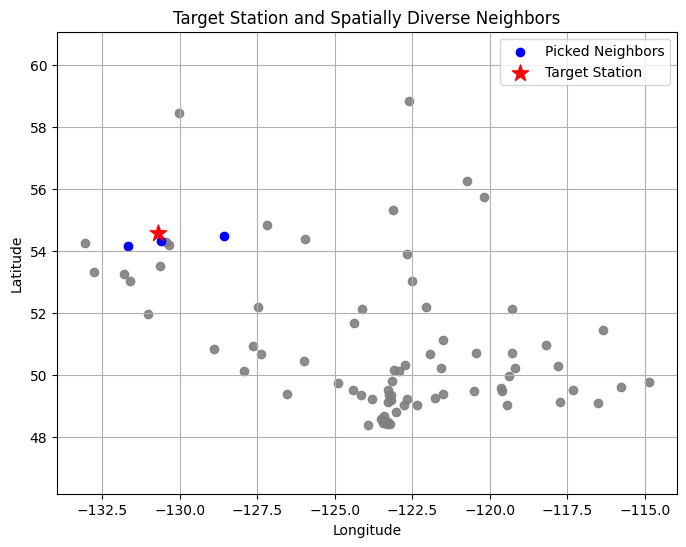

Station LUCY-ISLAND-LIGHTSTATION found in Datasets/CWEEDS_2020_BC\CAN_BC_LUCY-ISLAND-LIGHTSTATION_1064728_CWEEDS2011_1999-2017.csv
Station ROSE-SPIT-(AUT) found in Datasets/CWEEDS_2020_BC\CAN_BC_ROSE-SPIT-(AUT)_1056869_CWEEDS2011_1998-2017.csv
Station TERRACE-A found in Datasets/CWEEDS_2020_BC\CAN_BC_TERRACE-A_1068134_CWEEDS2011_1998-2017.csv


In [52]:
wanted_station_data_dfs, wanted_station_name, aux_dfs_list, aux_station_order, meanGHI, stdGHI = getAllReadyForStationByLatAndLongAndKNoChunking(stationsName_lat_long_datadf.copy(), -130.5, 54.5, 3)

In [ ]:
# wanted_station_data_dfs = wanted_station_data_dfs.iloc[1:].reset_index(drop=True)
# aux_dfs_list[0] = aux_dfs_list[0].iloc[:-1].reset_index(drop=True)
# aux_dfs_list[1] = aux_dfs_list[1].iloc[:-1].reset_index(drop=True)
# aux_dfs_list[2] = aux_dfs_list[2].iloc[:-1].reset_index(drop=True)

In [207]:
import pandas as pd

n = len(wanted_station_data_dfs)
wanted_df = wanted_station_data_dfs.copy()
wanted_df["hour"] = [i % 24 for i in range(n)]

towards_cases = []
away_cases = []

for i, aux in enumerate(aux_dfs_list, start=1):
    merged = pd.DataFrame({
        "year": wanted_df["Year"],
        "month": wanted_df["Month"],
        "day": wanted_df["Day"],
        "hour": wanted_df["hour"],
        "GHI_wanted": wanted_df["Global horizontal irradiance / kJ/m2"].values,
        "GHI_aux": aux["Global horizontal irradiance / kJ/m2"].values,
        "wind_dir": aux["Wind direction / 0-359 degrees"].values,
        "wind_speed": aux["Wind speed / 0.1 m/s"].values,
    })

    # Next-hour wanted station GHI
    merged["GHI_wanted_next"] = merged["GHI_wanted"].shift(-1)

    # ✅ Only keep cases where wanted station’s hour is 7–17
    merged = merged[(merged["hour"] >= 7) & (merged["hour"] <= 17)]

    # Define wind conditions
    merged["towards"] = (merged["wind_dir"] <= 10) | (merged["wind_dir"] >= 350)
    merged["away"] = (merged["wind_dir"] >= 165) & (merged["wind_dir"] <= 195)

    # Save subsets with station label
    cols = ["year", "month", "day", "hour", "GHI_wanted", "GHI_aux", "GHI_wanted_next", "wind_dir", "wind_speed"]
    towards_cases.append(merged[merged["towards"]][cols].assign(aux_station=f"aux_{i}"))
    away_cases.append(merged[merged["away"]][cols].assign(aux_station=f"aux_{i}"))

towards_df = pd.concat(towards_cases, ignore_index=True)
away_df = pd.concat(away_cases, ignore_index=True)


In [210]:
towards_df["GHI_change"] = towards_df["GHI_wanted_next"] - towards_df["GHI_wanted"]
away_df["GHI_change"] = away_df["GHI_wanted_next"] - away_df["GHI_wanted"]

In [211]:
towards_df = towards_df.assign(case="towards")
away_df = away_df.assign(case="away")

plot_df = pd.concat([towards_df, away_df], ignore_index=True)

In [197]:
towards = plot_df[plot_df["case"] == "towards"]

corr = towards[["wind_speed", "GHI_change"]].corr().iloc[0,1]
print(f"Correlation between wind speed and GHI change: {corr:.2f}")

Correlation between wind speed and GHI change: -0.04


In [198]:
# Add 'hour' if not already present (0-23)
plot_df["hour"] = [i % 24 for i in range(len(plot_df))]

hourly_summary = plot_df.groupby(["hour","case"])["GHI_change"].agg(["mean","count"]).reset_index()
print(hourly_summary)


    hour     case       mean  count
0      0     away  41.545455    484
1      0  towards   7.450755   1655
2      1     away  16.783058    484
3      1  towards  -3.118429   1655
4      2     away  45.324380    484
5      2  towards  -6.940785   1655
6      3     away  35.654959    484
7      3  towards   7.967372   1655
8      4     away  29.756198    484
9      4  towards   4.749245   1655
10     5     away  45.097107    484
11     5  towards  -3.810876   1655
12     6     away  19.993802    484
13     6  towards   0.450151   1655
14     7     away  55.181818    484
15     7  towards   6.731118   1655
16     8     away  26.717526    485
17     8  towards -12.969166   1654
18     9     away  12.457732    485
19     9  towards  -6.629383   1654
20    10     away  12.053608    485
21    10  towards   0.233374   1654
22    11     away  27.934021    485
23    11  towards  14.352479   1654
24    12     away  54.465979    485
25    12  towards  -4.293229   1654
26    13     away  -8.859794

In [199]:
from sklearn.linear_model import LinearRegression
import pandas as pd

df = plot_df.copy()

# Encode hours as dummy variables
hour_dummies = pd.get_dummies(df["hour"], prefix="hour")
X = pd.concat([df[["wind_speed"]], hour_dummies], axis=1)
y = df["GHI_change"]

model = LinearRegression()
model.fit(X, y)

print("Wind speed coefficient:", model.coef_[0])
print("Intercept:", model.intercept_)


Wind speed coefficient: -0.25324907158591375
Intercept: 28.431652855401353


In [200]:
hourly_diff = plot_df.groupby(["hour","case"])["GHI_change"].mean().unstack()
hourly_diff["towards_minus_away"] = hourly_diff["towards"] - hourly_diff["away"]

print(hourly_diff)


case       away    towards  towards_minus_away
hour                                          
0     41.545455   7.450755          -34.094699
1     16.783058  -3.118429          -19.901487
2     45.324380  -6.940785          -52.265166
3     35.654959   7.967372          -27.687587
4     29.756198   4.749245          -25.006954
5     45.097107  -3.810876          -48.907984
6     19.993802   0.450151          -19.543651
7     55.181818   6.731118          -48.450700
8     26.717526 -12.969166          -39.686691
9     12.457732  -6.629383          -19.087115
10    12.053608   0.233374          -11.820235
11    27.934021  14.352479          -13.581542
12    54.465979  -4.293229          -58.759208
13    -8.859794  10.085852           18.945646
14    -7.226804  17.740024           24.966828
15    24.411157  -9.411125          -33.822282
16    41.541322   4.117291          -37.424031
17    22.566116   6.054414          -16.511702
18     4.072314   7.770859            3.698544
19    47.1983

In [212]:
summary = (
    plot_df.groupby("case")
    .agg(
        n_total=("GHI_change", "size"),                                # how many times looked at
        n_changed=("GHI_change", lambda x: (x != 0).sum()),            # how many times changed
        mean_change=("GHI_change", "mean"),                            # avg change
    )
    .reset_index()
)
print(summary)

      case  n_total  n_changed  mean_change
0     away    11623      11156    27.261722
1  towards    28951      27366    -5.365721


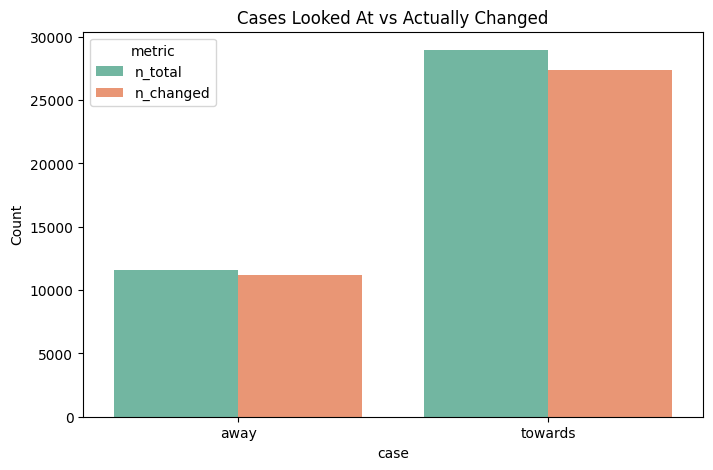

In [213]:
import matplotlib.pyplot as plt
import seaborn as sns

summary_melted = summary.melt(
    id_vars="case",
    value_vars=["n_total", "n_changed"],
    var_name="metric",
    value_name="count"
)

plt.figure(figsize=(8,5))
sns.barplot(data=summary_melted, x="case", y="count", hue="metric", palette="Set2")
plt.title("Cases Looked At vs Actually Changed")
plt.ylabel("Count")
plt.show()



In [214]:
towards_df.head(20)

,year,month,day,hour,GHI_wanted,GHI_aux,GHI_wanted_next,wind_dir,wind_speed,aux_station,GHI_change,case
0,1999,1,6,17,0,0,0.0,355.653119,56.0,aux_1,0.0,towards
1,1999,1,11,13,424,333,340.0,355.653119,47.0,aux_1,-84.0,towards
2,1999,1,12,14,170,169,37.0,5.653119,67.0,aux_1,-133.0,towards
3,1999,1,14,7,0,0,0.0,5.653119,108.0,aux_1,0.0,towards
4,1999,1,31,7,0,0,14.0,355.653119,150.0,aux_1,14.0,towards
5,1999,1,31,8,14,17,189.0,5.653119,128.0,aux_1,175.0,towards
6,1999,1,31,9,189,200,340.0,355.653119,133.0,aux_1,151.0,towards
7,1999,1,31,12,219,324,328.0,5.653119,92.0,aux_1,109.0,towards
8,1999,2,10,8,0,0,284.0,355.653119,128.0,aux_1,284.0,towards
9,1999,2,13,11,766,616,591.0,355.653119,156.0,aux_1,-175.0,towards


In [157]:
away_df.head(20)

,year,month,day,hour,GHI_wanted,GHI_aux,GHI_wanted_next,wind_dir,wind_speed,aux_station
0,1999,1,18,11,438,347,505.0,185.653119,56.0,aux_1
1,1999,1,18,12,505,389,419.0,185.653119,53.0,aux_1
2,1999,1,18,13,419,433,322.0,185.653119,53.0,aux_1
3,1999,1,18,14,322,308,293.0,175.653119,53.0,aux_1
4,1999,1,18,15,293,210,38.0,185.653119,61.0,aux_1
5,1999,1,18,16,38,36,0.0,175.653119,67.0,aux_1
6,1999,1,18,17,0,0,0.0,185.653119,89.0,aux_1
7,1999,1,19,7,0,0,0.0,175.653119,36.0,aux_1
8,1999,1,19,13,884,906,728.0,175.653119,36.0,aux_1
9,1999,1,19,17,0,0,0.0,185.653119,61.0,aux_1


In [133]:
wanted_station_data_dfs.head(20)

,Global horizontal irradiance / kJ/m2,Direct normal irradiance / kJ/m2,Diffuse horizontal irradiance / kJ/m2,Wind direction / 0-359 degrees,Wind speed / 0.1 m/s,Month,Hour,Hour_sin,Hour_cos,Month_sin,Month_cos,wind_dir_sin,wind_dir_cos
8760,0,0,0,140,92.0,1,1,0.000000e+00,1.000000e+00,0.0,1.0,0.642788,-7.660444e-01
8761,0,0,0,130,53.0,1,2,2.588190e-01,9.659258e-01,0.0,1.0,0.766044,-6.427876e-01
8762,0,0,0,140,67.0,1,3,5.000000e-01,8.660254e-01,0.0,1.0,0.642788,-7.660444e-01
8763,0,0,0,140,83.0,1,4,7.071068e-01,7.071068e-01,0.0,1.0,0.642788,-7.660444e-01
8764,0,0,0,140,97.0,1,5,8.660254e-01,5.000000e-01,0.0,1.0,0.642788,-7.660444e-01
8765,0,0,0,140,97.0,1,6,9.659258e-01,2.588190e-01,0.0,1.0,0.642788,-7.660444e-01
8766,0,0,0,130,92.0,1,7,1.000000e+00,6.123234e-17,0.0,1.0,0.766044,-6.427876e-01
8767,0,0,0,130,83.0,1,8,9.659258e-01,-2.588190e-01,0.0,1.0,0.766044,-6.427876e-01
8768,0,0,0,140,89.0,1,9,8.660254e-01,-5.000000e-01,0.0,1.0,0.642788,-7.660444e-01
8769,0,0,0,90,61.0,1,10,7.071068e-01,-7.071068e-01,0.0,1.0,1.000000,6.123234e-17


In [118]:
aux_dfs_list[0].head()

,Global horizontal irradiance / kJ/m2,Direct normal irradiance / kJ/m2,Diffuse horizontal irradiance / kJ/m2,Wind direction / 0-359 degrees,Wind speed / 0.1 m/s,wind_dir_sin,wind_dir_cos,distanceX,distanceY
0,-0.580535,-0.416357,-0.659953,325.653119,0.601335,-0.564202,0.825637,-8417.130391,6037.884517
1,-0.580535,-0.416357,-0.659953,325.653119,0.707153,-0.564202,0.825637,-8417.130391,6037.884517
2,-0.580535,-0.416357,-0.659953,325.653119,0.834135,-0.564202,0.825637,-8417.130391,6037.884517
3,-0.580535,-0.416357,-0.659953,325.653119,0.834135,-0.564202,0.825637,-8417.130391,6037.884517
4,-0.580535,-0.416357,-0.659953,325.653119,0.939953,-0.564202,0.825637,-8417.130391,6037.884517


## Looking at other data

Station ROSE-SPIT-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_ROSE-SPIT-(AUT)_1056869_CWEEDS2011_1998-2017.csv


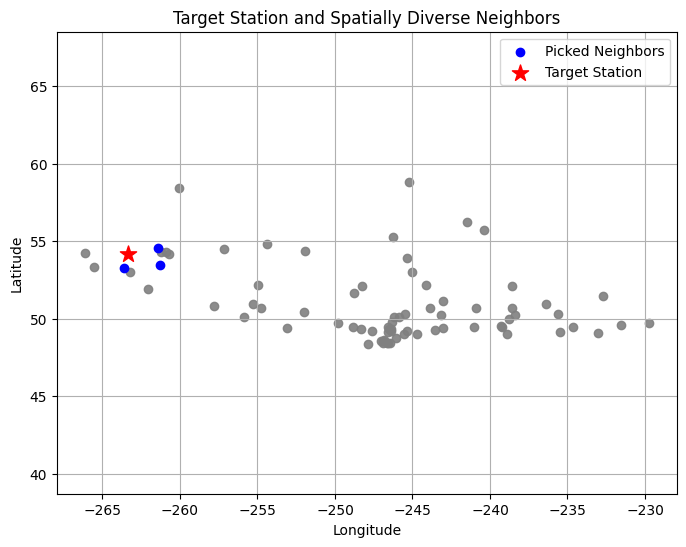

Station SANDSPIT found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SANDSPIT_1057052_CWEEDS2011_1998-2017.csv
Station GREY-ISLET-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_GREY-ISLET-(AUT)_1063303_CWEEDS2011_1998-2017.csv
Station BONILLA-ISLAND-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_BONILLA-ISLAND-(AUT)_1060R0K_CWEEDS2011_1998-2017.csv


In [ ]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -263.5, 54.5, 3)

In [ ]:
wanted_chunked_tensors[0].shape

torch.Size([175295, 25, 6])

In [ ]:
combined_chunked_data_tensor1 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

In [ ]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -246, 50,3)

Station ENTRANCE-ISLAND found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_ENTRANCE-ISLAND_1022689_CWEEDS2011_1998-2017.csv
Station VANCOUVER-INTL-A found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_VANCOUVER-INTL-A_1108395_CWEEDS2011_1998-2017.csv
Station PITT-MEADOWS-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_PITT-MEADOWS-CS_1106178_CWEEDS2011_1998-2017.csv
Station SANDHEADS-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_SANDHEADS-CS_1107010_CWEEDS2011_2003-2017.csv


In [ ]:
combined_chunked_data_tensor2 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

In [ ]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -247, 48,3)
combined_chunked_data_tensor3 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

Station PEMBERTON-AIRPORT-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_PEMBERTON-AIRPORT-CS_1086082_CWEEDS2011_1998-2017.csv
Station LYTTON-RCS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_LYTTON-RCS_1114746_CWEEDS2011_1998-2017.csv
Station CALLAGHAN-VALLEY found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_CALLAGHAN-VALLEY_1101300_CWEEDS2011_2005-2017.csv
Station WHISTLER---NESTERS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_WHISTLER---NESTERS_1100875_CWEEDS2011_2005-2017.csv


In [ ]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -245, 60,3)
combined_chunked_data_tensor4 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

Station WARFIELD-RCS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_WARFIELD-RCS_1148705_CWEEDS2011_2002-2017.csv
Station CRESTON-CAMPBELL-SCIENTIFIC found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_CRESTON-CAMPBELL-SCIENTIFIC_114B1F0_CWEEDS2011_1998-2017.csv
Station OSOYOOS-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_OSOYOOS-CS_1125852_CWEEDS2011_1998-2017.csv
Station NELSON-CS found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_NELSON-CS_1145M29_CWEEDS2011_1998-2017.csv


In [ ]:
wanted_chunked_tensors, wanted_station_name, aux_chunked_tensors, aux_chunked_station_order = getAllReadyForStationByLatAndLongAndK(stationsName_lat_long_datadf.copy(), -255.5, 51,3)
combined_chunked_data_tensor5 = torch.cat(wanted_chunked_tensors + aux_chunked_tensors, dim=2)

Station FORT-ST-JOHN-A found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_FORT-ST-JOHN-A_1183001_CWEEDS2011_1998-2017.csv
Station DAWSON-CREEK-A found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_DAWSON-CREEK-A_1182289_CWEEDS2011_1998-2017.csv
Station MACKENZIE found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_MACKENZIE_1184791_CWEEDS2011_1998-2017.csv
Station PRINCE-GEORGE found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_PRINCE-GEORGE_1096439_CWEEDS2011_1998-2017.csv


In [ ]:
combined_chunked_data_tensor = torch.cat([combined_chunked_data_tensor1, combined_chunked_data_tensor2, combined_chunked_data_tensor3, combined_chunked_data_tensor4, combined_chunked_data_tensor5], dim=0)

In [ ]:
combined_chunked_data_tensor.shape

torch.Size([718699, 25, 30])

In [22]:
'''
Wanted:
Global horizontal irradiance / kJ/m2',
'Direct normal irradiance / kJ/m2',
'Diffuse horizontal irradiance / kJ/m2',
'Wind speed / 0.1 m/s',
'wind_dir_sin',
'wind_dir_cos'

Nearest*3:
Global horizontal irradiance / kJ/m2',
'Direct normal irradiance / kJ/m2',
'Diffuse horizontal irradiance / kJ/m2',
'Wind speed / 0.1 m/s',
'wind_dir_sin',
'wind_dir_cos',
'distanceX',
'distanceY
'''

"\nWanted:\nGlobal horizontal irradiance / kJ/m2',\n'Direct normal irradiance / kJ/m2',\n'Diffuse horizontal irradiance / kJ/m2',\n'Wind speed / 0.1 m/s',\n'wind_dir_sin',\n'wind_dir_cos'\n\nNearest*3:\nGlobal horizontal irradiance / kJ/m2',\n'Direct normal irradiance / kJ/m2',\n'Diffuse horizontal irradiance / kJ/m2',\n'Wind speed / 0.1 m/s',\n'wind_dir_sin',\n'wind_dir_cos',\n'distanceX',\n'distanceY\n"

## Covariance Matrix and wind visualization

In [32]:
usecolsWind = [
    'Year Month Day Hour (YYYYMMDDHH)',
    'Global horizontal irradiance / kJ/m2',
    'Wind direction / 0-359 degrees',
    'Wind speed / 0.1 m/s',

]
#'Minutes of sunshine / 0-60 minutes',

dtypeWind= {
    'Year Month Day Hour (YYYYMMDDHH)': str,  # Read as string initially to handle errors
    'Wind direction / 0-359 degrees': str,
    'Wind speed / 0.1 m/s': str,
    'Global horizontal irradiance / kJ/m2': str,
}
# 'Minutes of sunshine / 0-60 minutes': str,

In [33]:
def get_nearest_stations_wind_data(station_CSVs):
      dfs = []
      i = 0
      windSpeedAves = []
      # Read the CSV file with specified columns and data types
      for f in station_CSVs:
      # Read the CSV file with specified columns and data types
        dfW = pd.read_csv(f, delimiter=',', skiprows=2, index_col=False, usecols=usecolsWind, dtype=dtypeWind, on_bad_lines='skip')

        # Convert columns to numeric, coercing errors to NaN
        for col in usecolsWind:
          if(col == 'Year Month Day Hour (YYYYMMDDHH)'):
                dfW['Hour'] = dfW['Year Month Day Hour (YYYYMMDDHH)'].str[8:10].astype(int)
                dfW = dfW.drop(columns=[col], axis=1)
                continue

          if(col=='Wind direction / 0-359 degrees'):
                dfW[col] = pd.to_numeric(dfW[col], errors='coerce').replace(99, np.nan) #Real values are only in increments of 5 or 10 from 0 to 360
                dfW[col] = pd.to_numeric(dfW[col], errors='coerce').replace(360, 0)
                radians = np.deg2rad(dfW[col])
                dfW["Wind direction rads"] = radians
                continue

          if(col == 'Wind speed / 0.1 m/s'):
                dfW[col] = pd.to_numeric(dfW[col], errors='coerce').replace(99, np.nan)
                continue

          if (col == 'Global horizontal irradiance / kJ/m2'):
              dfW[col] = pd.to_numeric(dfW[col], errors='coerce').replace(9999, np.nan)
              continue

          dfW[col] = pd.to_numeric(dfW[col], errors='coerce')
        dfW["elevation"] = stationsName_lat_long_datadf["Elevation"].values[i]
        dfW["station"] = stationsName_lat_long_datadf["station"].values[i]
        i+=1
        windSpeedMean = dfW['Wind speed / 0.1 m/s'].mean()
        windSpeedAves.append(windSpeedMean)
        dfW.fillna(0, inplace=True)
        dfs.append(dfW)
      return dfs, windSpeedAves

In [25]:
WindDatadfs, windSpeedMeans = get_nearest_stations_wind_data(csv_files)

In [31]:
WindDatadfs[0].head()

,Global horizontal irradiance / kJ/m2,Wind direction / 0-359 degrees,Wind speed / 0.1 m/s,Hour,Wind direction rads,elevation,station
0,0,250,25,1,4.363323,20,AGASSIZ RCS
1,0,220,31,2,3.839724,20,AGASSIZ RCS
2,0,240,31,3,4.188790,20,AGASSIZ RCS
3,0,250,42,4,4.363323,20,AGASSIZ RCS
4,0,210,19,5,3.665191,20,AGASSIZ RCS


In [ ]:
kNearestStations = find_k_nearest_stations(stationsName_lat_long_datadf, WindDatadfs[0]["station"][0], 3)
kNearestStations

,station,norm_lat,norm_long,distance,StartTime,EndTime,Latitude,Longitude
42,PITT MEADOWS CS,0.079350,0.570407,"(0.0054849146766522035, (-0.002868068833652107...",1998,2017,49.21,-245.38
65,VANCOUVER INTL A,0.077438,0.543454,"(0.010880944827766421, (-0.004780114722753706,...",1998,2017,49.19,-246.36
26,HOPE A,0.094646,0.635864,"(0.012632829183293823, (0.012428298279158298, ...",2005,2017,49.37,-243.00


In [70]:
station_datadf1 = WindDatadfs[0][['Global horizontal irradiance / kJ/m2',
       'Wind direction / 0-359 degrees', 'Wind speed / 0.1 m/s',
       'Wind direction rads' ]]
station_datadf2 = WindDatadfs[42][['Global horizontal irradiance / kJ/m2',
       'Wind direction / 0-359 degrees', 'Wind speed / 0.1 m/s',
       'Wind direction rads' ]]
station_datadf3 = WindDatadfs[65][['Global horizontal irradiance / kJ/m2',
       'Wind direction / 0-359 degrees', 'Wind speed / 0.1 m/s',
       'Wind direction rads' ]]
station_datadf4 = WindDatadfs[26][['Global horizontal irradiance / kJ/m2',
       'Wind direction / 0-359 degrees', 'Wind speed / 0.1 m/s',
       'Wind direction rads' ]]

allStationsdfs = [station_datadf1, station_datadf2, station_datadf3, station_datadf4]



In [71]:
allStationsdfsHourBefore = None
station_datadf1 = station_datadf1.iloc[:-1].reset_index(drop=True) #removing last row to represent an hour after auxiliary stations

station_datadf2 = station_datadf2.iloc[1:].reset_index(drop=True) #removing first row to represent an hour before main station
station_datadf3 = station_datadf3.iloc[1:].reset_index(drop=True) #removing first row to represent an hour before main station
station_datadf4 = station_datadf4.iloc[1:].reset_index(drop=True) #removing first row to represent an hour before main station
allStationsdfsHourBefore = [station_datadf1, station_datadf2, station_datadf3, station_datadf4]

In [72]:
allStationsdfs[0].columns = [f'wanted_{col}' for col in allStationsdfs[0].columns]
i = 0
for df in allStationsdfs:
  if i == 0:
    i=1
    continue
  df.columns = [f'aux{i}_{col}' for col in df.columns]
  i+=1

Combined_dfs = pd.concat(allStationsdfs, axis=1)

In [73]:
Combined_dfsHourBefore = None
allStationsdfsHourBefore[0].columns = [f'wanted_{col}' for col in allStationsdfsHourBefore[0].columns]
i = 0
for df in allStationsdfsHourBefore:
  if i == 0:
    i=1
    continue
  df.columns = [f'aux{i}_{col}' for col in df.columns]
  i+=1

Combined_dfsHourBefore = pd.concat(allStationsdfsHourBefore, axis=1)

In [74]:
Combined_dfs.head()

,wanted_Global horizontal irradiance / kJ/m2,wanted_Wind direction / 0-359 degrees,wanted_Wind speed / 0.1 m/s,wanted_Wind direction rads,aux1_Global horizontal irradiance / kJ/m2,aux1_Wind direction / 0-359 degrees,aux1_Wind speed / 0.1 m/s,aux1_Wind direction rads,aux2_Global horizontal irradiance / kJ/m2,aux2_Wind direction / 0-359 degrees,aux2_Wind speed / 0.1 m/s,aux2_Wind direction rads,aux3_Global horizontal irradiance / kJ/m2,aux3_Wind direction / 0-359 degrees,aux3_Wind speed / 0.1 m/s,aux3_Wind direction rads
0,0,250,25,4.363323,0,100,11,1.745329,0,0,25,0.000000,0.0,110.0,97.0,1.919862
1,0,220,31,3.839724,0,320,19,5.585054,0,10,31,0.174533,0.0,120.0,103.0,2.094395
2,0,240,31,4.188790,0,60,11,1.047198,0,10,31,0.174533,0.0,120.0,92.0,2.094395
3,0,250,42,4.363323,0,120,11,2.094395,0,10,25,0.174533,0.0,130.0,103.0,2.268928
4,0,210,19,3.665191,0,120,6,2.094395,0,10,19,0.174533,0.0,120.0,103.0,2.094395


In [75]:
Combined_dfsHourBefore.head()

,wanted_Global horizontal irradiance / kJ/m2,wanted_Wind direction / 0-359 degrees,wanted_Wind speed / 0.1 m/s,wanted_Wind direction rads,aux1_Global horizontal irradiance / kJ/m2,aux1_Wind direction / 0-359 degrees,aux1_Wind speed / 0.1 m/s,aux1_Wind direction rads,aux2_Global horizontal irradiance / kJ/m2,aux2_Wind direction / 0-359 degrees,aux2_Wind speed / 0.1 m/s,aux2_Wind direction rads,aux3_Global horizontal irradiance / kJ/m2,aux3_Wind direction / 0-359 degrees,aux3_Wind speed / 0.1 m/s,aux3_Wind direction rads
0,0,250,25,4.363323,0,320,19,5.585054,0,10,31,0.174533,0.0,120.0,103.0,2.094395
1,0,220,31,3.839724,0,60,11,1.047198,0,10,31,0.174533,0.0,120.0,92.0,2.094395
2,0,240,31,4.188790,0,120,11,2.094395,0,10,25,0.174533,0.0,130.0,103.0,2.268928
3,0,250,42,4.363323,0,120,6,2.094395,0,10,19,0.174533,0.0,120.0,103.0,2.094395
4,0,210,19,3.665191,0,150,17,2.617994,0,10,25,0.174533,0.0,110.0,114.0,1.919862


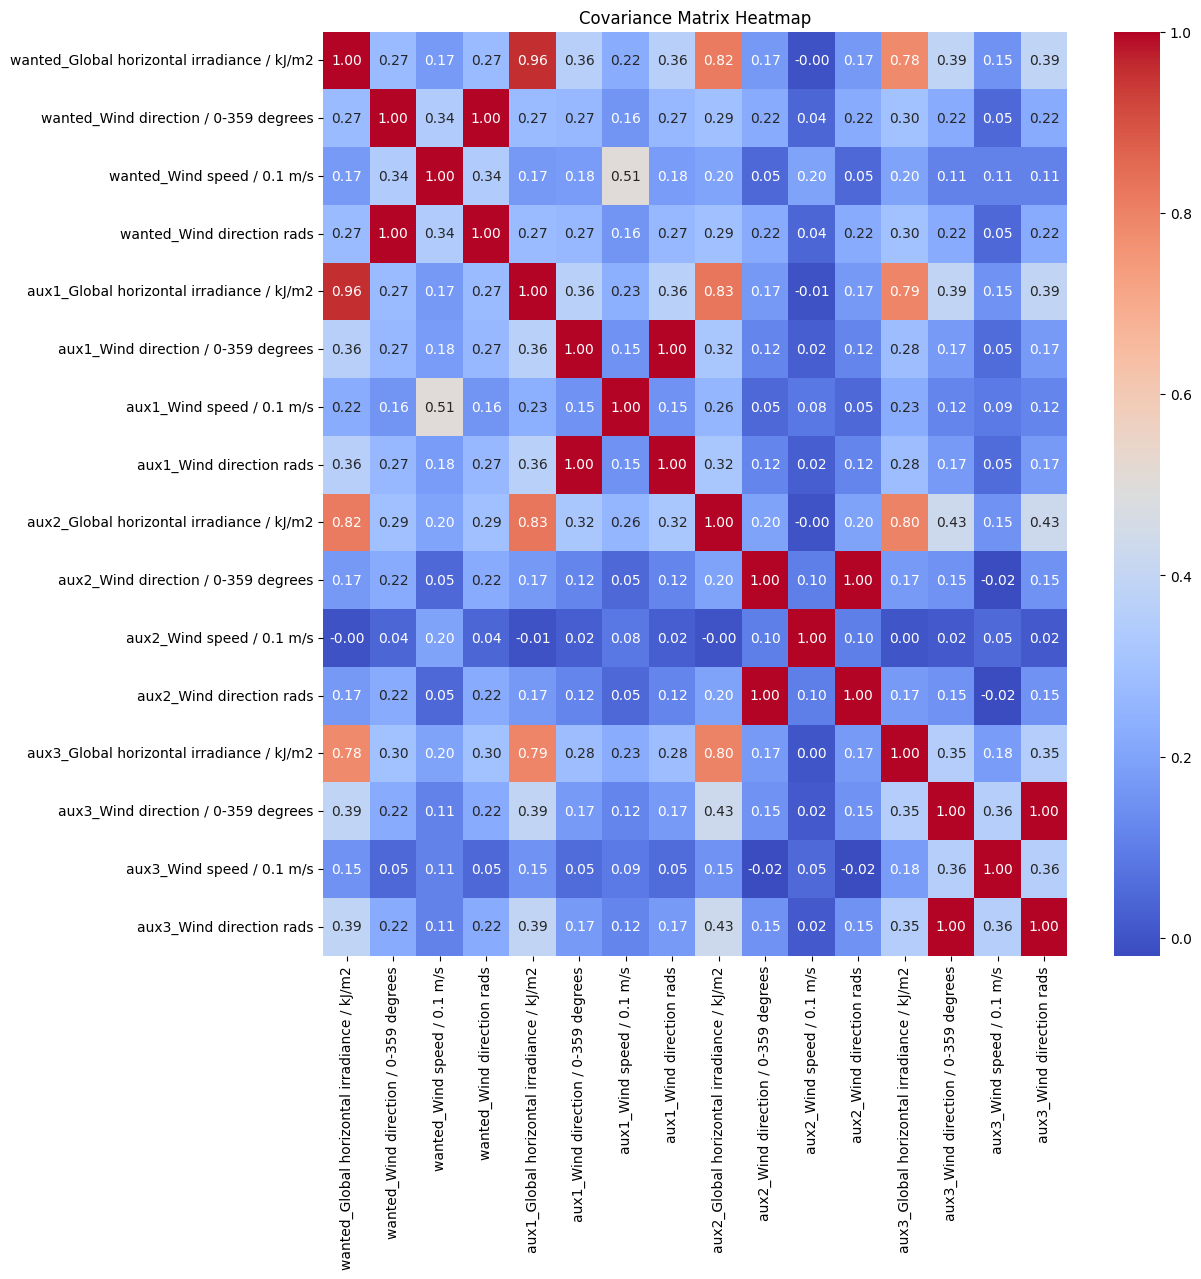

In [34]:
cov_matrix = Combined_dfs.cov()
corr_matrix = Combined_dfs.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Set the title and show the plot
plt.title('Covariance Matrix Heatmap')
plt.show()

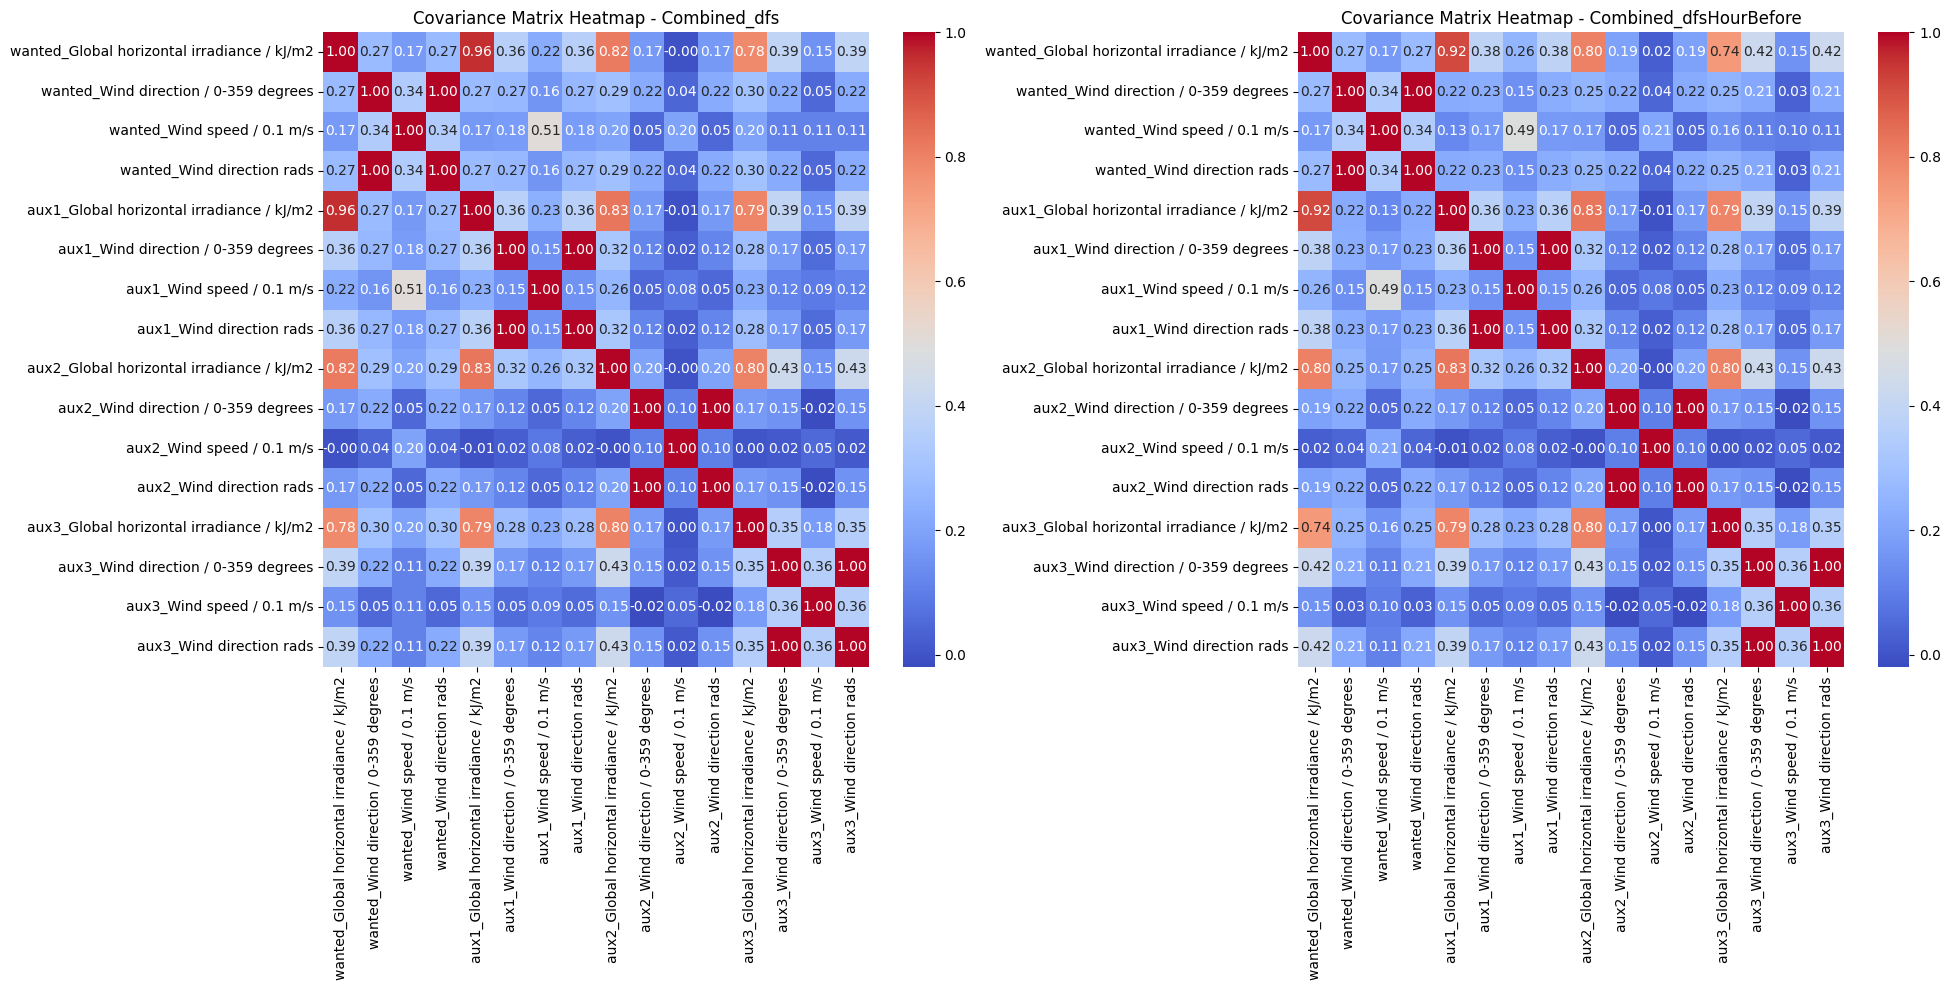

In [76]:
# Compute covariance & correlation for both
cov_matrix1 = Combined_dfs.cov()
corr_matrix1 = Combined_dfs.corr()

cov_matrix2 = Combined_dfsHourBefore.cov()
corr_matrix2 = Combined_dfsHourBefore.corr()

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# First heatmap
sns.heatmap(
    corr_matrix1, annot=True, cmap='coolwarm', fmt='.2f',
    cbar=True, ax=axes[0]
)
axes[0].set_title("Covariance Matrix Heatmap - Combined_dfs")

# Second heatmap
sns.heatmap(
    corr_matrix2, annot=True, cmap='coolwarm', fmt='.2f',
    cbar=True, ax=axes[1]
)
axes[1].set_title("Covariance Matrix Heatmap - Combined_dfsHourBefore")

plt.tight_layout()
plt.show()

In [ ]:
station_datadf = WindDatadfs[0][['Global horizontal irradiance / kJ/m2',
       'Wind direction / 0-359 degrees', 'Wind speed / 0.1 m/s', 'Hour',
       'Wind direction rads' ]]
cov_matrix = station_datadf.cov()
corr_matrix = station_datadf.corr()
cov_matrix

,Global horizontal irradiance / kJ/m2,Wind direction / 0-359 degrees,Wind speed / 0.1 m/s,Hour,Wind direction rads
Global horizontal irradiance / kJ/m2,599489.860067,20649.519716,1101.513188,144.377794,360.402108
Wind direction / 0-359 degrees,20649.519716,13411.013358,-127.973829,30.381647,234.066339
Wind speed / 0.1 m/s,1101.513188,-127.973829,383.925833,-3.609158,-2.233565
Hour,144.377794,30.381647,-3.609158,47.916940,0.530260
Wind direction rads,360.402108,234.066339,-2.233565,0.530260,4.085228


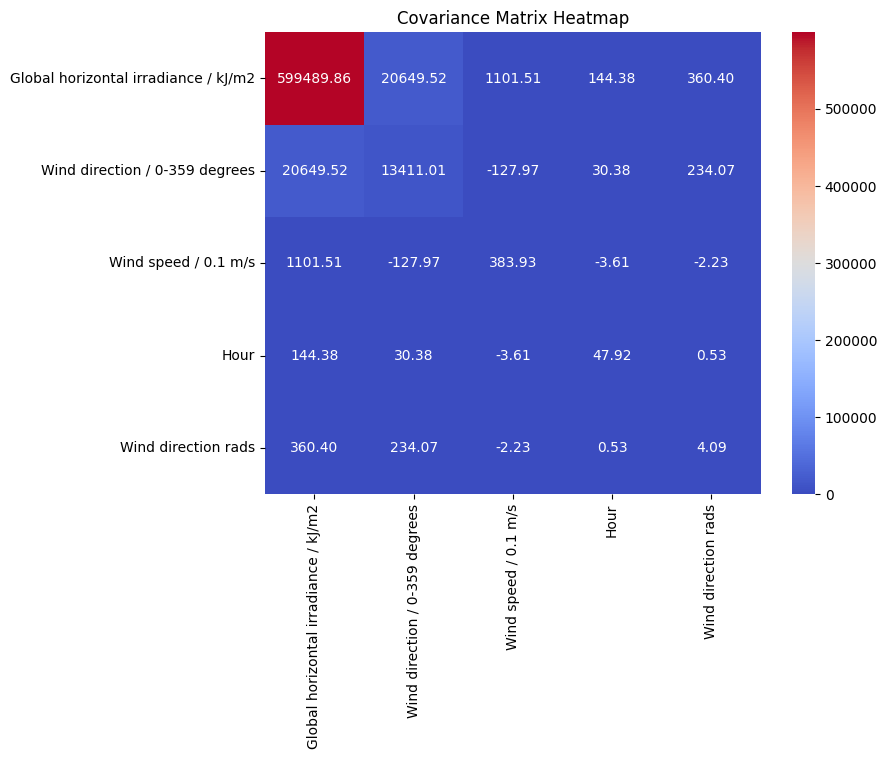

In [ ]:

plt.figure(figsize=(8, 6))
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Set the title and show the plot
plt.title('Covariance Matrix Heatmap')
plt.show()

In [ ]:
corr_matrix

,Global horizontal irradiance / kJ/m2,Wind direction / 0-359 degrees,Wind speed / 0.1 m/s,Hour,Wind direction rads
Global horizontal irradiance / kJ/m2,1.000000,0.230297,0.072606,0.026938,0.230297
Wind direction / 0-359 degrees,0.230297,1.000000,-0.056398,0.037900,1.000000
Wind speed / 0.1 m/s,0.072606,-0.056398,1.000000,-0.026610,-0.056398
Hour,0.026938,0.037900,-0.026610,1.000000,0.037900
Wind direction rads,0.230297,1.000000,-0.056398,0.037900,1.000000


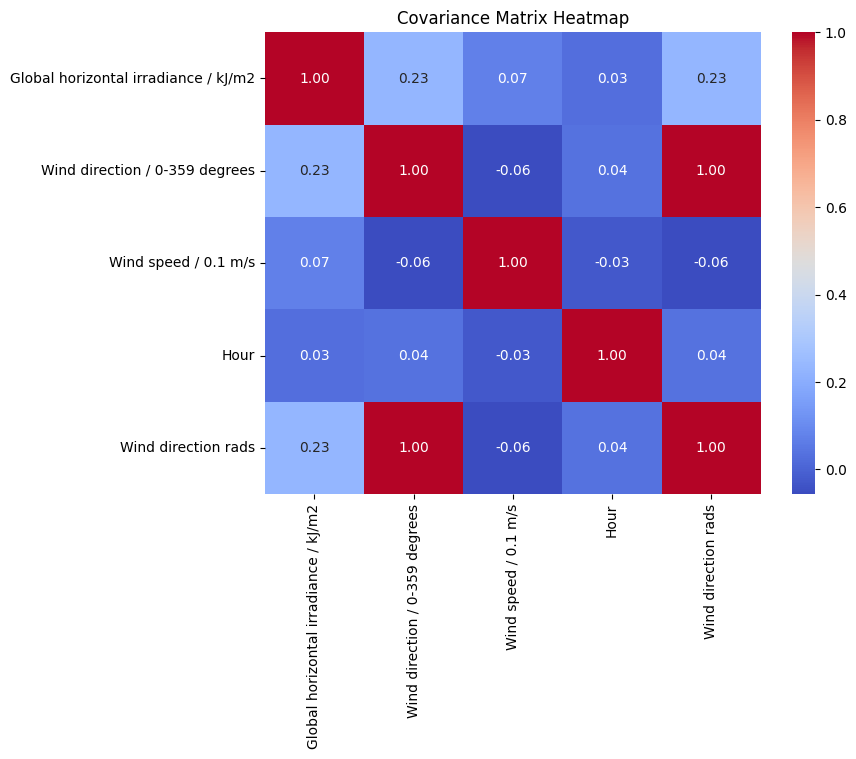

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)

# Set the title and show the plot
plt.title('Covariance Matrix Heatmap')
plt.show()

In [ ]:
def getAveGHIatHourx(WindDatadfs, hour):
  aveGHIatHourx = []
  for df in WindDatadfs:
    mean_value = df.loc[df['Hour'] == hour, 'Global horizontal irradiance / kJ/m2'].mean()
    aveGHIatHourx.append(mean_value)
  return aveGHIatHourx

In [ ]:
aveGHIatHour12 = getAveGHIatHourx(WindDatadfs, 12)

In [ ]:
station_names = stationsName_lat_long_datadf["station"].values
elevations = stationsName_lat_long_datadf["Elevation"].values
lats = stationsName_lat_long_datadf["Latitude"].values
longs = stationsName_lat_long_datadf["LongitudeNot2"].values
plot_df = pd.DataFrame({'Station': station_names, 'Average Wind Speed': windSpeedMeans, "Elevation": elevations, "Latitude": lats, "Longitude": longs})
plot_df = plot_df.sort_values(by='Elevation')

In [ ]:
plot_df

,Station,Average Wind Speed,Elevation,Latitude,Longitude
2,BONILLA ISLAND (AUT),70.877417,0.0,53.49,-130.64
4,BALLENAS ISLAND,55.882402,0.0,49.35,-124.16
7,CAPE ST JAMES,82.659189,0.0,51.94,-131.02
8,CATHEDRAL POINT (AUT),54.262449,0.0,52.19,-127.47
12,CUMSHEWA ISLAND,58.151021,0.0,53.03,-131.60
...,...,...,...,...,...
6,CALLAGHAN VALLEY,9.465459,923.0,50.14,-123.11
75,WILLIAMS LAKE A,27.847901,932.0,52.18,-122.05
10,CRANBROOK A,23.397901,935.0,49.61,-115.78
61,SPARWOOD CS,22.926009,1134.0,49.75,-114.88


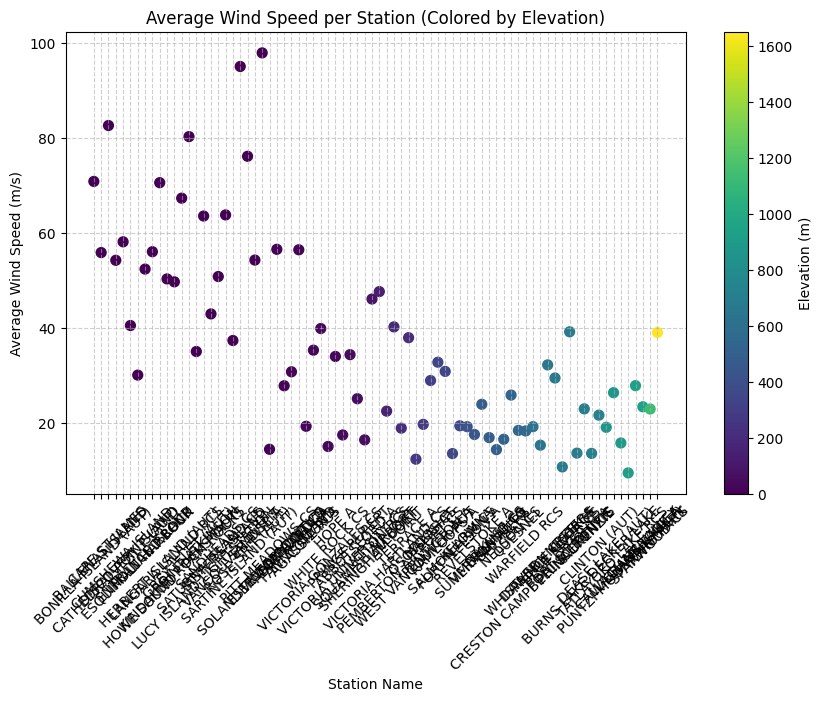

In [ ]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(plot_df['Station'], plot_df['Average Wind Speed'], c=plot_df['Elevation'], cmap='viridis', s=50)
plt.colorbar(sc, label='Elevation (m)')
plt.xlabel("Station Name")
plt.ylabel("Average Wind Speed (m/s)")
plt.title("Average Wind Speed per Station (Colored by Elevation)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

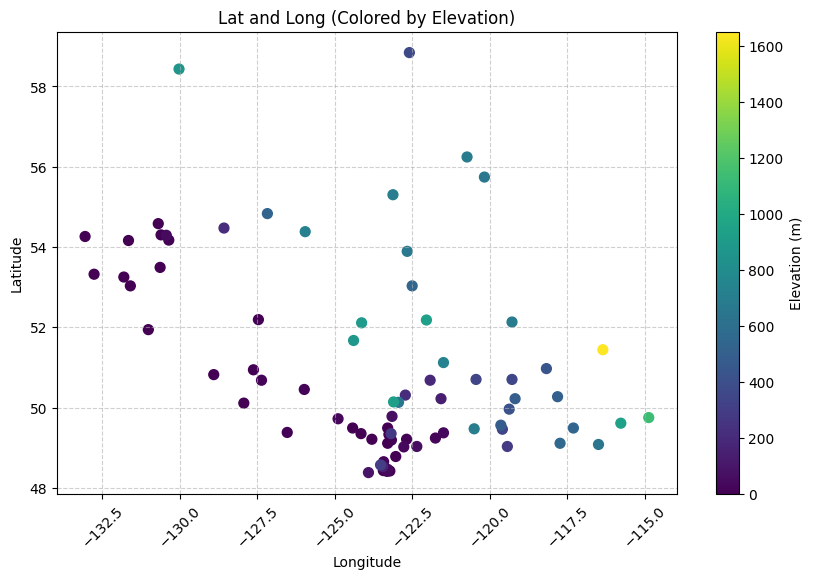

In [ ]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(plot_df['Longitude'], plot_df['Latitude'], c=plot_df['Elevation'], cmap='viridis', s=50)
plt.colorbar(sc, label='Elevation (m)')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Lat and Long (Colored by Elevation)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

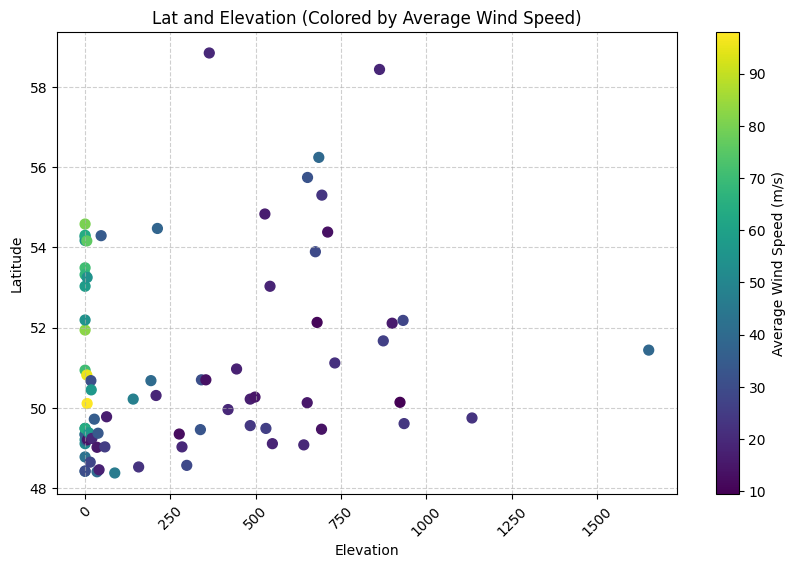

In [ ]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(plot_df['Elevation'], plot_df['Latitude'], c=plot_df['Average Wind Speed'], cmap='viridis', s=50)
plt.colorbar(sc, label='Average Wind Speed (m/s)')
plt.xlabel("Elevation")
plt.ylabel("Latitude")
plt.title("Lat and Elevation (Colored by Average Wind Speed)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

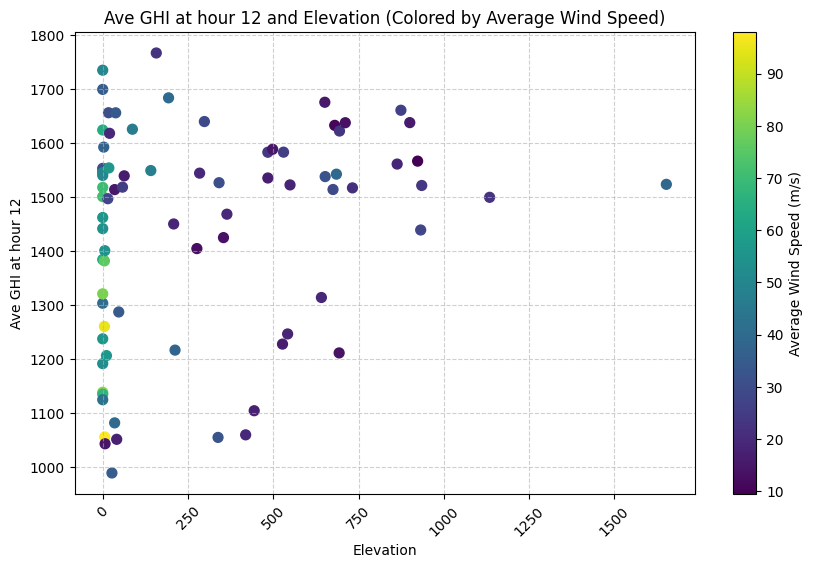

In [ ]:
plt.figure(figsize=(10, 6))
sc = plt.scatter(plot_df['Elevation'], aveGHIatHour12, c=plot_df['Average Wind Speed'], cmap='viridis', s=50)
plt.colorbar(sc, label='Average Wind Speed (m/s)')
plt.xlabel("Elevation")
plt.ylabel("Ave GHI at hour 12")
plt.title("Ave GHI at hour 12 and Elevation (Colored by Average Wind Speed)")
plt.xticks(rotation=45)  # Rotate x-axis labels if needed
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [29]:
wanted_station = find_nearest_station_given_normed_long_lat(stationsName_lat_long_datadf, -0.5, 0.2)
print(str(wanted_station.station.iloc[0]))
wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
print(wanted_station)

SHERINGHAM POINT
             station  norm_lat  norm_long           distance  StartTime  \
57  SHERINGHAM POINT       0.0    0.50275  (0.0, (0.0, 0.0))       1998   

    EndTime  Latitude  Longitude  
57     2017     48.38    -123.92  


In [35]:
station_CSV = ""
modified_station = str(wanted_station.station.iloc[0]).replace(" ", "-")
for csv in csv_files:
    if str(modified_station).lower() in csv.lower():
        station_CSV = csv
        print(f"Station {str(wanted_station.station.iloc[0])} found in {csv}")
        break


Station SHERINGHAM POINT found in Datasets/CWEEDS_2020_BC\CAN_BC_SHERINGHAM-POINT_1017254_CWEEDS2011_1998-2017.csv


In [47]:
WindData, windSpeedAves = get_nearest_stations_wind_data([station_CSV])
WindData = WindData[0]
windSpeedAves = windSpeedAves[0]
np.unique(WindData["Wind direction rads"])

array([0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
       1.74532925, 1.91986218, 2.0943951 , 2.26892803, 2.44346095,
       2.61799388, 2.7925268 , 2.96705973, 3.14159265, 3.31612558,
       3.4906585 , 3.66519143, 3.83972435, 4.01425728, 4.1887902 ,
       4.36332313, 4.53785606, 4.71238898, 4.88692191, 5.06145483,
       5.23598776, 5.41052068, 5.58505361, 5.75958653, 5.93411946,
       6.10865238])

In [51]:
windSpeedAves

np.float64(46.09744467259868)

In [50]:
WindData

,Global horizontal irradiance / kJ/m2,Wind direction / 0-359 degrees,Wind speed / 0.1 m/s,Hour,Wind direction rads,elevation,station
0,0,290,61,1,5.061455,20,AGASSIZ RCS
1,0,220,19,2,3.839724,20,AGASSIZ RCS
2,0,300,67,3,5.235988,20,AGASSIZ RCS
3,0,290,89,4,5.061455,20,AGASSIZ RCS
4,0,290,92,5,5.061455,20,AGASSIZ RCS
...,...,...,...,...,...,...,...
175315,0,80,39,20,1.396263,20,AGASSIZ RCS
175316,0,80,31,21,1.396263,20,AGASSIZ RCS
175317,0,80,31,22,1.396263,20,AGASSIZ RCS
175318,0,70,28,23,1.221730,20,AGASSIZ RCS


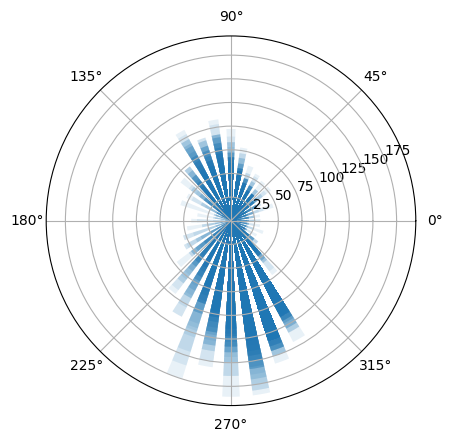

In [49]:
N = 20
theta = WindData["Wind direction rads"][0:8760]
radii = WindData['Wind speed / 0.1 m/s'][0:8760]
width = 0.1

ax = plt.subplot(projection='polar')
#ax = plt.subplot()
ax.bar(theta, radii, width=width, bottom=0.0, alpha=0.1)
plt.show()

In [77]:
def get_stations_data(nearest_stations_csvs, min_start_year, max_end_year, wantedStationCSV=False, RelativeAnglesDegrees=[(0,0)]):
    dfs = []
    i = 0
    for f in nearest_stations_csvs:
      # Read the CSV file with specified columns and data types
      df = pd.read_csv(f, delimiter=',', skiprows=2, index_col=False, usecols=usecols, dtype=dtype, on_bad_lines='skip')
      # Convert columns to numeric, coercing errors to NaN
      for col in usecols:
          if(col == 'Year Month Day Hour (YYYYMMDDHH)'):
              #keep as string
              df['Year Month Day Hour (YYYYMMDDHH)'] = [int(num) for num in df['Year Month Day Hour (YYYYMMDDHH)']]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']>min_start_year]
              df = df[df['Year Month Day Hour (YYYYMMDDHH)']<=max_end_year]#Data is between min_start_year and max_end_year to accomidate files that dont have the same amount of data
              df['Year Month Day Hour (YYYYMMDDHH)'] = df['Year Month Day Hour (YYYYMMDDHH)'].astype(str)
              # Get month (1-12)
              df['Month'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[4:6].astype(int)
              # Get hour (1-24)
              df['Hour'] = df['Year Month Day Hour (YYYYMMDDHH)'].str[8:10].astype(int)
              df = df.drop(columns=[col], axis=1)
              continue

          if(col=='Wind direction / 0-359 degrees'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              if(not wantedStationCSV):
                df[col] = df[col].apply(lambda x: adjustWindDirection(x, RelativeAnglesDegrees[i]))
                #When wind is pointed towards the wanted station it has a new angle of 0 degrees and when pointed directly away from it it has a 180 degrees value now
              continue

          if(col == 'Wind speed / 0.1 m/s'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(99, np.nan)
              continue

          if (col == 'Global horizontal irradiance / kJ/m2' or col == 'Direct normal irradiance / kJ/m2' or col == 'Diffuse horizontal irradiance / kJ/m2'):
              df[col] = pd.to_numeric(df[col], errors='coerce').replace(9999, np.nan)
              if (col == 'Global horizontal irradiance / kJ/m2'):
                df["GHI"] = df[col]
                df = df.drop(columns=[col], axis=1)
              continue
          df[col] = pd.to_numeric(df[col], errors='coerce')
      df.fillna(0, inplace=True)
      dfs.append(df)
      i+=1
      #print(df.columns)
    return dfs

In [78]:
def Analysis_getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, min_start_year, max_end_year, RelativeAnglesDegrees):
  #doing all thats needed to get Auxillary stations data ready and in chunked tensors and in order chunked
  modified_nearest_stations = modify_nearest_stations(nearest_stations)
  nearest_stations_csvs, station_order = find_stations_csv(modified_nearest_stations, csv_files)
  nearest_stations_data_dfs = get_stations_data(nearest_stations_csvs, min_start_year, max_end_year, False, RelativeAnglesDegrees)

  for i in range(k):
    nearest_stations_data_dfs[i]["distanceX"] = [nearest_stations['distance'].values[i][1][0]]*len(nearest_stations_data_dfs[i])
    nearest_stations_data_dfs[i]["distanceY"] = [nearest_stations['distance'].values[i][1][1]]*len(nearest_stations_data_dfs[i])
    #print(nearest_stations_data_dfs[i].columns)
  return nearest_stations_data_dfs, station_order

In [79]:
def Analysis_getAllReadyForStationByNormedLatAndLongAndK(stationsName_lat_long_datadf, lat, long, k):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_normed_long_lat(stationsName_lat_long_datadf, lat, long)
  wanted_station_lat_long = (wanted_station["Latitude"],wanted_station["Longitude"])
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)

  nearest_stations = find_k_nearest_stations(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)
  nearest_stations_lat_long =[]
  for station in nearest_stations:
     nearest_stations_lat_long.append((station["Latitude"],station["Longitude"]))
  max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)
  max_start_year, min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year)

  RelativeAnglesDegrees = []
  for distanceVector in nearest_stations["distance"].values:
    Relative_Angle_Radians = np.arctan2(distanceVector[1][1], distanceVector[1][0])#Relative Distance Vector y and Distance Vector x
    Relative_Angle_Degrees = np.degrees(Relative_Angle_Radians)
    if Relative_Angle_Degrees < 0:
      Relative_Angle_Degrees += 360
    RelativeAnglesDegrees.append(Relative_Angle_Degrees)


  nearest_stations_data_dfs, aux_station_order = Analysis_getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, max_start_year, min_end_year, RelativeAnglesDegrees)

  wanted_station_data_dfs = get_stations_data(wanted_station_csv, max_start_year, min_end_year, True)

  return wanted_station_data_dfs, wanted_station["station"].values[0], nearest_stations_data_dfs, aux_station_order, nearest_stations_lat_long, wanted_station_lat_long

In [80]:
wanted_station_data_dfs, wanted_station_name, nearest_stations_data_dfs, aux_station_order, nearest_stations_lat_long, wanted_station_lat_long = Analysis_getAllReadyForStationByNormedLatAndLongAndK(stationsName_lat_long_datadf, 0.52, 0.08, 3)

Station ROSE-SPIT-(AUT) found in Datasets/CWEEDS_2020_BC\CAN_BC_ROSE-SPIT-(AUT)_1056869_CWEEDS2011_1998-2017.csv


TypeError: string indices must be integers, not 'str'

In [ ]:
wanted_station_data_dfs[0].columns = [f'wanted_{col}' for col in wanted_station_data_dfs[0].columns]
i = 1
for df in nearest_stations_data_dfs:
  df.columns = [f'aux{i}_{col}' for col in df.columns]
  i+=1

Combined_dfs = pd.concat([wanted_station_data_dfs[0]] + nearest_stations_data_dfs, axis=1)

In [ ]:
Combined_dfs.head()

,wanted_Direct normal irradiance / kJ/m2,wanted_Diffuse horizontal irradiance / kJ/m2,wanted_Wind direction / 0-359 degrees,wanted_Wind speed / 0.1 m/s,wanted_Month,wanted_Hour,wanted_GHI,aux1_Direct normal irradiance / kJ/m2,aux1_Diffuse horizontal irradiance / kJ/m2,aux1_Wind direction / 0-359 degrees,...,aux2_distanceY,aux3_Direct normal irradiance / kJ/m2,aux3_Diffuse horizontal irradiance / kJ/m2,aux3_Wind direction / 0-359 degrees,aux3_Wind speed / 0.1 m/s,aux3_Month,aux3_Hour,aux3_GHI,aux3_distanceX,aux3_distanceY
8760,0.0,0.0,180.0,25.0,1.0,1.0,0.0,0.0,0.0,20.765977,...,-0.077008,0.0,0.0,343.047412,11.0,1.0,1.0,0.0,0.013384,0.057756
8761,0.0,0.0,180.0,31.0,1.0,2.0,0.0,0.0,0.0,50.765977,...,-0.077008,0.0,0.0,333.047412,25.0,1.0,2.0,0.0,0.013384,0.057756
8762,0.0,0.0,170.0,25.0,1.0,3.0,0.0,0.0,0.0,50.765977,...,-0.077008,0.0,0.0,13.047412,25.0,1.0,3.0,0.0,0.013384,0.057756
8763,0.0,0.0,140.0,56.0,1.0,4.0,0.0,0.0,0.0,50.765977,...,-0.077008,0.0,0.0,43.047412,47.0,1.0,4.0,0.0,0.013384,0.057756
8764,0.0,0.0,150.0,92.0,1.0,5.0,0.0,0.0,0.0,60.765977,...,-0.077008,0.0,0.0,53.047412,36.0,1.0,5.0,0.0,0.013384,0.057756


In [ ]:
'''
Wanted:
'Month'.
'Hour',
'Global horizontal irradiance / kJ/m2',
'Direct normal irradiance / kJ/m2',
'Diffuse horizontal irradiance / kJ/m2',
'Wind speed / 0.1 m/s',
'wind_dir'

Nearest*3:
'Month'.
'Hour',
'Global horizontal irradiance / kJ/m2',
'Direct normal irradiance / kJ/m2',
'Diffuse horizontal irradiance / kJ/m2',
'Wind speed / 0.1 m/s',
'wind_dir',
'distanceX',
'distanceY
'''

In [ ]:
hourly_ghi = {
    'Hour': range(24),  # Binning by hour (0 to 23)
    'wanted_GHI_avg': [],
    'aux1_GHI_avg': [],
    'aux2_GHI_avg': [],
    'aux3_GHI_avg': []
}
hour = 1.0
for i in range(24):
    # Filter the rows where the Hour equals the current hour
    wanted_ghi_hour = Combined_dfs[Combined_dfs['wanted_Hour'] == hour]['wanted_GHI'].mean()
    aux1_ghi_hour = Combined_dfs[Combined_dfs['aux1_Hour'] == hour]['aux1_GHI'].mean()
    aux2_ghi_hour = Combined_dfs[Combined_dfs['aux2_Hour'] == hour]['aux2_GHI'].mean()
    aux3_ghi_hour = Combined_dfs[Combined_dfs['aux3_Hour'] == hour]['aux3_GHI'].mean()

    # Append the average values to the dictionary
    hourly_ghi['wanted_GHI_avg'].append(wanted_ghi_hour)
    hourly_ghi['aux1_GHI_avg'].append(aux1_ghi_hour)
    hourly_ghi['aux2_GHI_avg'].append(aux2_ghi_hour)
    hourly_ghi['aux3_GHI_avg'].append(aux3_ghi_hour)
    hour += 1.0

# Step 3: Create a DataFrame with the average GHI values
hourly_df = pd.DataFrame(hourly_ghi)

In [ ]:
hourly_df.head()

,Hour,wanted_GHI_avg,aux1_GHI_avg,aux2_GHI_avg,aux3_GHI_avg
0,0,0.00000,0.000000,0.00000,0.000000
1,1,0.00000,0.000000,0.00000,0.000000
2,2,0.00000,0.000000,0.00000,0.000000
3,3,0.00000,0.000000,0.00000,0.000000
4,4,1.58692,1.471331,1.89384,1.492928


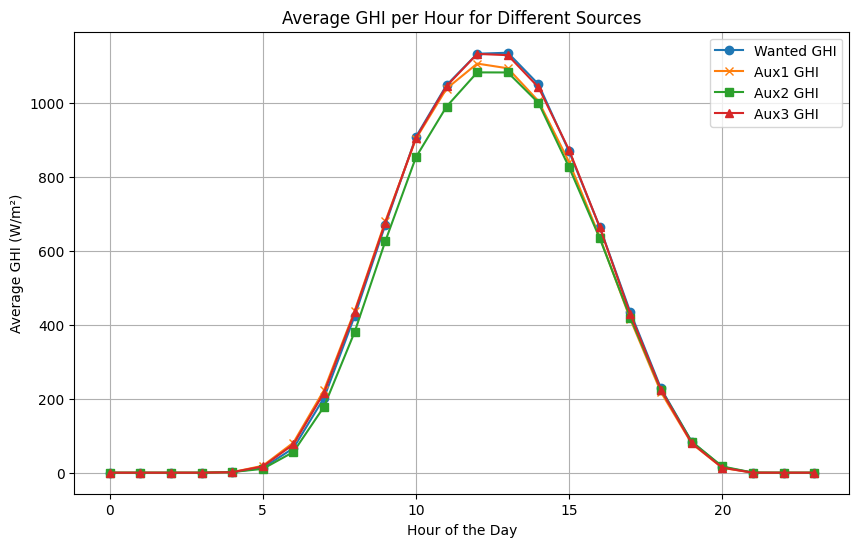

In [ ]:
plt.figure(figsize=(10, 6))

# Plotting the GHI data for each source
plt.plot(hourly_df['Hour'], hourly_df['wanted_GHI_avg'], label='Wanted GHI', marker='o')
plt.plot(hourly_df['Hour'], hourly_df['aux1_GHI_avg'], label='Aux1 GHI', marker='x')
plt.plot(hourly_df['Hour'], hourly_df['aux2_GHI_avg'], label='Aux2 GHI', marker='s')
plt.plot(hourly_df['Hour'], hourly_df['aux3_GHI_avg'], label='Aux3 GHI', marker='^')

# Adding labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average GHI (W/m²)')
plt.title('Average GHI per Hour for Different Sources')

# Show the legend and grid
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [ ]:
#!pip install requests
import requests

In [ ]:
# script for returning elevation from lat, long, based on open elevation data
# which in turn is based on SRTM
def get_elevation(lat, long):
    # Open-Elevation API query
    query = f'https://api.open-elevation.com/api/v1/lookup?locations={lat},{long}'

    # Make the request and get the JSON response
    r = requests.get(query).json()

    # Normalize the JSON response to extract elevation
    elevation = pd.json_normalize(r['results'])['elevation'].values[0]

    return elevation

In [ ]:
lat = 37.7749  # Example: San Francisco
long = -122.4194

elevation = get_elevation(lat, long)
print(f"Elevation at ({lat}, {long}) is {elevation} meters.")

Elevation at (37.7749, -122.4194) is 16.0 meters.


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# file_path = '/content/drive/MyDrive/Colab Notebooks/stationsName_lat_long_data.csv'
file_path = 'Datasets/stationsName_lat_long_data.csv'

In [ ]:
stationsName_lat_long_datadf

,Latitude,Longitude,LongitudeNot2,station,StartTime,EndTime,norm_lat,norm_long,Elevation,distance
0,49.24,-243.52,-121.76,AGASSIZ RCS,1998,2017,0.082218,0.621562,20.0,"(404.4603999999996, (-5.259999999999998, 19.97..."
1,49.03,-244.72,-122.36,ABBOTSFORD A,1998,2017,0.062141,0.588559,58.0,"(358.15840000000003, (-5.469999999999999, 18.78))"
2,53.49,-261.28,-130.64,BONILLA ISLAND (AUT),1998,2017,0.488528,0.133113,0.0,"(5.93840000000012, (-1.009999999999998, 2.2200..."
3,52.13,-238.58,-119.29,BLUE RIVER CS,1998,2017,0.358509,0.757426,680.0,"(623.3763999999994, (-2.3699999999999974, 24.9..."
4,49.35,-248.32,-124.16,BALLENAS ISLAND,2000,2017,0.092734,0.489549,0.0,"(235.5824000000002, (-5.149999999999999, 15.18..."
...,...,...,...,...,...,...,...,...,...,...
73,50.13,-245.90,-122.95,WHISTLER - NESTERS,2005,2017,0.167304,0.556106,651.0,"(314.1299999999998, (-4.369999999999997, 17.59..."
74,49.35,-246.38,-123.19,WEST VANCOUVER AUT,1998,2017,0.092734,0.542904,276.0,"(298.24440000000016, (-5.149999999999999, 17.1..."
75,52.18,-244.10,-122.05,WILLIAMS LAKE A,1998,2017,0.363289,0.605611,932.0,"(378.68000000000023, (-2.3200000000000003, 19...."
76,51.44,-232.72,-116.36,YOHO PARK,1998,2017,0.292543,0.918592,1652.0,"(950.4684, (-3.0600000000000023, 30.78))"


In [ ]:
stationsName_lat_long_datadf_copy = stationsName_lat_long_datadf.copy()
stationsName_lat_long_datadf_copy["Longitude"] = stationsName_lat_long_datadf["LongitudeNot2"]
stationsName_lat_long_datadf_copy["LongitudeNot2"] = stationsName_lat_long_datadf["Longitude"]
stationsName_lat_long_datadf_copy.rename(columns={'LongitudeNot2': 'LongitudeTimes2'}, inplace=True)
stationsName_lat_long_datadf_copy.head()

,Latitude,Longitude,LongitudeTimes2,station,StartTime,EndTime,norm_lat,norm_long,Elevation
0,49.24,-121.76,-243.52,AGASSIZ RCS,1998,2017,0.082218,0.621562,20.0
1,49.03,-122.36,-244.72,ABBOTSFORD A,1998,2017,0.062141,0.588559,58.0
2,53.49,-130.64,-261.28,BONILLA ISLAND (AUT),1998,2017,0.488528,0.133113,0.0
3,52.13,-119.29,-238.58,BLUE RIVER CS,1998,2017,0.358509,0.757426,680.0
4,49.35,-124.16,-248.32,BALLENAS ISLAND,2000,2017,0.092734,0.489549,0.0


In [ ]:
lat_min = stationsName_lat_long_datadf_copy["Latitude"].min()
lat_max = stationsName_lat_long_datadf_copy["Latitude"].max()
long_min = stationsName_lat_long_datadf_copy["Longitude"].min()
long_max = stationsName_lat_long_datadf_copy["Longitude"].max()

In [ ]:
stationsName_lat_long_datadf_copy[['norm_lat', 'norm_long']] = stationsName_lat_long_datadf_copy.apply(lambda row: normalize_lat_lon(row['Latitude'], row['Longitude']), axis=1, result_type='expand')

In [ ]:
stationsName_lat_long_datadf_copy.head()

,Latitude,Longitude,LongitudeTimes2,station,StartTime,EndTime,norm_lat,norm_long,Elevation
0,49.24,-121.76,-243.52,AGASSIZ RCS,1998,2017,0.082218,0.621562,20.0
1,49.03,-122.36,-244.72,ABBOTSFORD A,1998,2017,0.062141,0.588559,58.0
2,53.49,-130.64,-261.28,BONILLA ISLAND (AUT),1998,2017,0.488528,0.133113,0.0
3,52.13,-119.29,-238.58,BLUE RIVER CS,1998,2017,0.358509,0.757426,680.0
4,49.35,-124.16,-248.32,BALLENAS ISLAND,2000,2017,0.092734,0.489549,0.0


In [ ]:
stationsName_lat_long_datadf_copy.to_csv(file_path, index=False)

In [ ]:
# elevations = []
# for index, station in stationsName_lat_long_datadf.iterrows():
#   lat = station["Latitude"]  # Example: San Francisco
#   long = station["LongitudeNot2"]

#   elevation = get_elevation(lat, long)
#   elevations.append(elevation)
#   print(f"Elevation at ({lat}, {long}) is {elevation} meters.")
# stationsName_lat_long_datadf["Elevation"] = elevations
# stationsName_lat_long_datadf

In [ ]:
# stationsName_lat_long_datadf.to_csv(file_path, index=False)

In [ ]:
len(csv_files)

78

In [ ]:
def latlon_to_xy(lat, lon, lat0):
    """Simple equirectangular projection."""
    R = 6371  # radius in km
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return x, y

def compute_angle(vec1, vec2):
    norm1 = np.linalg.norm(vec1)
    norm2 = np.linalg.norm(vec2)
    if norm1 == 0 or norm2 == 0:
        return 0  # Could return np.pi to maximize diversity if desired
    unit1 = vec1 / norm1
    unit2 = vec2 / norm2
    return np.arccos(np.clip(np.dot(unit1, unit2), -1.0, 1.0))

def spatially_diverse_knn(df,station_name, k=3, candidate_pool=len(csv_files)):
    # Exclude the center point if it exists in the set
    if station_name not in df['station'].values:
      return f"Station {station_name} not found in the dataset."

    center_latlon = df[df['station'] == station_name][['Latitude', 'Longitude']].values[0]
    mask = ~((df['Latitude'] == center_latlon[0]) & (df['Longitude'] == center_latlon[1]))
    df_filtered = df[mask].copy()

    # Convert to x/y coords
    lat0 = center_latlon[0]
    df_filtered['x'], df_filtered['y'] = latlon_to_xy(df_filtered['Latitude'], df_filtered['Longitude'], lat0)
    center_x, center_y = latlon_to_xy(center_latlon[0], center_latlon[1], lat0)
    center_xy = np.array([center_x, center_y])

    # Compute distances
    df_filtered['distance'] = np.linalg.norm(df_filtered[['x', 'y']].values - center_xy, axis=1)
    df_sorted = df_filtered.sort_values('distance').head(candidate_pool)

    selected_rows = []
    selected_xy = []

    for idx, row in df_sorted.iterrows():
        cand_xy = np.array([row['x'], row['y']])
        if len(selected_xy) == 0:
            selected_rows.append(row)
            selected_xy.append(cand_xy)
        else:
            angles = [compute_angle(cand_xy - center_xy, s - center_xy) for s in selected_xy]
            min_angle = min(angles)
            if min_angle > np.radians(45) or len(selected_xy) < k // 2:
                selected_rows.append(row)
                selected_xy.append(cand_xy)
        if len(selected_rows) == k:
            break

    return pd.DataFrame(selected_rows).drop(columns=['x', 'y', 'distance']).reset_index(drop=True), center_latlon

In [ ]:
def plot_stations_matplotlib(center_latlon, neighbors_df, all_stations_df, figsize=(8, 6)):
    center_lat, center_lon = center_latlon

    # Create set of picked station names for easy lookup
    picked_names = set(neighbors_df['station'])

    plt.figure(figsize=figsize)

    # Plot unpicked stations (from all_stations_df, excluding the neighbors and center)
    for _, row in all_stations_df.iterrows():
        if (row['Latitude'], row['Longitude']) == tuple(center_latlon):
            continue
        if row['station'] not in picked_names:
            plt.scatter(row['Longitude'], row['Latitude'], color='gray', alpha=0.9, label='_nolegend_')
            #plt.text(row['Longitude'] + 0.002, row['Latitude'], row['station'], fontsize=8, color='gray')

    # Plot the selected neighbor stations
    plt.scatter(
        neighbors_df['Longitude'],
        neighbors_df['Latitude'],
        color='blue',
        label='Picked Neighbors'
    )
    # for _, row in neighbors_df.iterrows():
    #     plt.text(row['Longitude'] + 0.002, row['Latitude'], row['station'], fontsize=9)

    # Plot the target station
    plt.scatter(center_lon, center_lat, color='red', marker='*', s=150, label='Target Station')
    #plt.text(center_lon + 0.002, center_lat, 'Target', fontsize=10, fontweight='bold')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Target Station and Spatially Diverse Neighbors')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()

In [ ]:
def getAllReadyForStationByNormedLatAndLongAndK(stationsName_lat_long_datadf, lat, long, k):
  #doing everything needed to get wanted stations data ready and in chunked tensors as well as get wanted station and its name
  wanted_station = find_nearest_station_given_long_lat(stationsName_lat_long_datadf, lat, long)
  max_start_year = wanted_station["StartTime"].values[0]
  min_end_year = wanted_station["EndTime"].values[0]

  wanted_station.at[wanted_station.index[0], "distance"] = (0.0, (0.0, 0.0))
  wanted_station_modified = modify_nearest_stations({"station": wanted_station["station"]})
  wanted_station_csv, _ = find_stations_csv(wanted_station_modified, csv_files)
  neighbors, target_point = spatially_diverse_knn(stationsName_lat_long_datadf,  wanted_station["station"].values[0], k)

  print("Selected neighbors:")
  print(neighbors)
  plot_stations_matplotlib(target_point, neighbors,stationsName_lat_long_datadf)
  #nearest_stations = spatially_diverse_knn(stationsName_lat_long_datadf, wanted_station["station"].values[0], k)

  # max_start_year, min_end_year = max(max_start_year, *nearest_stations["StartTime"].values), min(min_end_year, *nearest_stations["EndTime"].values)
  # max_start_year, min_end_year = getMaxStartMinEndYearComplete(max_start_year, min_end_year)

  # aux_chunked_tensors, aux_chunked_station_order = getAllKAuxillaryStationsReadyByWantedStationName(stationsName_lat_long_datadf, nearest_stations, k, max_start_year, min_end_year)

  wanted_station_data_dfs = get_nearest_stations_data(wanted_station_csv, max_start_year, min_end_year)
  # wanted_chunked_tensors, _ = get_chunked_tensors(wanted_station, wanted_station_data_dfs, 25)

  return wanted_station_data_dfs, wanted_station["station"].values[0]

Station ROSE-SPIT-(AUT) found in /content/drive/MyDrive/Colab Notebooks/CWEEDS_2020_BC/CAN_BC_ROSE-SPIT-(AUT)_1056869_CWEEDS2011_1998-2017.csv
Selected neighbors:
   Latitude  Longitude  LongitudeNot2               station  StartTime  \
0     53.25    -263.62        -131.81              SANDSPIT       1998   
1     54.58    -261.40        -130.70      GREY ISLET (AUT)       1998   
2     53.49    -261.28        -130.64  BONILLA ISLAND (AUT)       1998   

   EndTime  norm_lat  norm_long  Elevation  
0     2017  0.465583   0.068757        6.0  
1     2017  0.592734   0.129813        0.0  
2     2017  0.488528   0.133113        0.0  


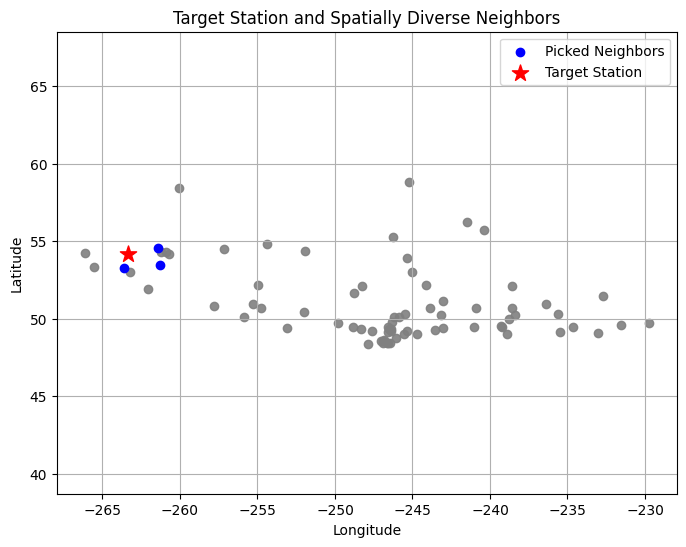

In [ ]:
wanted_station_data_dfs, wanted_station_name = getAllReadyForStationByNormedLatAndLongAndK(stationsName_lat_long_datadf,-263.5, 54.5, 3)

## Testing Distances


In [ ]:
import matplotlib.pyplot as plt

# Assuming you already defined haversine() and find_best_cross()

def plot_stations_matplotlib(center_latlon, neighbors_df, all_stations_df, figsize=(8, 6)):
    center_lat, center_lon = center_latlon

    picked_names = set(neighbors_df['station'])

    plt.figure(figsize=figsize)

    # Plot all stations except center + neighbors
    for _, row in all_stations_df.iterrows():
        if (row['Latitude'], row['Longitude']) == tuple(center_latlon):
            continue
        if row['station'] not in picked_names:
            plt.scatter(row['Longitude'], row['Latitude'], color='gray', alpha=0.7, label='_nolegend_')

    # Plot selected neighbors
    plt.scatter(
        neighbors_df['Longitude'],
        neighbors_df['Latitude'],
        color='blue',
        s=80,
        label='Picked Neighbors'
    )
    for _, row in neighbors_df.iterrows():
        plt.text(row['Longitude'] + 0.01, row['Latitude'] + 0.01,
                 row['station'], fontsize=8, color='blue')

    # Plot the target station
    plt.scatter(center_lon, center_lat, color='red', marker='*', s=200, label='Target Station')
    plt.text(center_lon + 0.01, center_lat + 0.01, 'Target', fontsize=9, fontweight='bold', color='red')

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Best Balanced Station with N/S/E/W Neighbors')
    plt.legend()
    plt.grid(True)
    plt.gca().set_aspect('equal', adjustable='datalim')
    plt.show()


In [66]:
import itertools
import numpy as np
import pandas as pd

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2*R*np.arcsin(np.sqrt(a))

def find_best_cross(df):
    """
    For each station, try to find N, S, E, W neighbors.
    Pick the combination with the most balanced distances.
    """
    best_score = np.inf
    best_center = None
    best_cross = None

    for _, center in df.iterrows():
        center_lat, center_lon = center['Latitude'], center['Longitude']
        name = center['station']

        # Compute distances
        df_temp = df.copy()
        df_temp['distance'] = df_temp.apply(
            lambda r: haversine(center_lat, center_lon, r['Latitude'], r['Longitude']), axis=1
        )
        df_temp = df_temp[df_temp['station'] != name]

        # Split into directions
        north = df_temp[df_temp['Latitude'] > center_lat]
        south = df_temp[df_temp['Latitude'] < center_lat]
        east  = df_temp[df_temp['Longitude'] > center_lon]
        west  = df_temp[df_temp['Longitude'] < center_lon]

        # Skip if one direction is missing
        if north.empty or south.empty or east.empty or west.empty:
            continue

        # Try all possible combinations (cartesian product of N/S/E/W choices)
        combos = itertools.product(
            north.index, south.index, east.index, west.index
        )

        for n_idx, s_idx, e_idx, w_idx in combos:
            n = df_temp.loc[n_idx]
            s = df_temp.loc[s_idx]
            e = df_temp.loc[e_idx]
            w = df_temp.loc[w_idx]

            distances = [n['distance'], s['distance'], e['distance'], w['distance']]
            score = max(distances) - min(distances)  # balance score

            if score < best_score:
                best_score = score
                best_center = center
                best_cross = pd.DataFrame([n, s, e, w])


    return best_center, best_cross, best_score


In [67]:
best_center, best_cross, best_score = find_best_cross(stationsName_lat_long_datadf)

Best station: PEMBERTON AIRPORT CS (balance score 0.00 km)


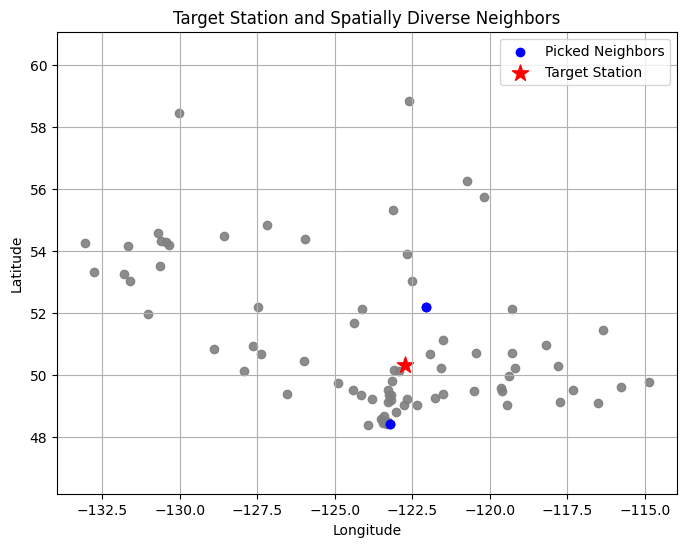

In [69]:
if best_center is not None:
    center_latlon = (best_center['Latitude'], best_center['Longitude'])
    print(f"Best station: {best_center['station']} (balance score {best_score:.2f} km)")
    plot_stations_matplotlib(center_latlon, best_cross, stationsName_lat_long_datadf)
else:
    print("No valid balanced station found.")

In [57]:
best_center

Latitude                                                      48.78
Longitude                                                   -123.04
LongitudeTimes2                                             -246.08
station                                           SATURNA ISLAND CS
StartTime                                                      2001
EndTime                                                        2017
norm_lat                                                   0.038241
norm_long                                                  0.551155
Elevation                                                         0
distance           (0.6615508334929734, (0.538240918, 0.351155116))
Name: 55, dtype: object

In [58]:
best_cross

,Latitude,Longitude,LongitudeTimes2,station,StartTime,EndTime,norm_lat,norm_long,Elevation,distance
77,49.02,-122.78,-245.56,WHITE ROCK CS,1998,2017,0.061185,0.565457,35,32.762444
70,48.65,-123.43,-246.86,VICTORIA INTL A,1998,2017,0.025813,0.529703,15,32.057196
77,49.02,-122.78,-245.56,WHITE ROCK CS,1998,2017,0.061185,0.565457,35,32.762444
70,48.65,-123.43,-246.86,VICTORIA INTL A,1998,2017,0.025813,0.529703,15,32.057196


In [59]:
best_score

np.float64(0.705248316749973)